# DIGI405 Text Analysis Project Notebook

[Version 0.2.1 - 2025-08-19](https://github.com/polsci/DIGI405-assignments/blob/main/CHANGELOG.md) - ensure filtering / grid search handled as expected   
Note: Search notebook for 0.2.1 to find changes if you want to apply to your notebook.

**Author:**  Ivinny Barros de Araujo  
**Date:**  September 2025

Select the Python 3.12 kernel to run the code in this notebook. 

# Introduction

This notebook focuses on classifying tweet sentiments into two categories: positive and negative. It builds and compares the performance of two supervised learning models: Logistic Regression and Random Forest Classifier.

The feature extraction pipeline combines different types of linguistic and statistical information:

- Text-level statistical features (such as readability and length measures) --- Also called as base model
- Token-based features using TF-IDF with unigrams and bigrams,
- Part-of-speech (POS) features, and
- Lexicon features from Empath and VADER.

These features are tested both individually and in combination to understand their impact on classification accuracy.

| Feature Type         | Description                                                                 | Evaluated for Impact |
|----------------------|------------------------------------------------------------------------------|----------------------|
| Text-Level Statistics| Length, punctuation, lexical richness, readability metrics                  | Yes  |
| Lexicons (VADER)     | Rule-based sentiment scores tuned for social media                          | Yes |
| Lexicons (Empath)    | Category-based semantic features (e.g. joy, anger, politics)                | Yes |
| Token Features       | TF-IDF vectorization of unigrams and bigrams                                | Yes |
| POS Features         | Frequency and distribution of part-of-speech tags                           | Yes |



This notebook was developed as part of the coursework for the Texts, Discourses, and Data paper from the Postgraduate Diploma in Data Science program at the University of Canterbury.

Dataset: https://huggingface.co/datasets/cardiffnlp/tweet_eval/viewer/sentiment

# 1. Setup

In [1]:
from datasets import load_dataset, ClassLabel, DatasetDict
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.feature_selection import SelectKBest, mutual_info_classif, chi2
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import FeatureUnion
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier

from textplumber.core import *
from textplumber.clean import *
from textplumber.preprocess import *
from textplumber.tokens import *
from textplumber.pos import *
from textplumber.embeddings import *
from textplumber.report import *
from textplumber.store import *
from textplumber.lexicons import *
from textplumber.textstats import *

from imblearn.under_sampling import RandomUnderSampler
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import seaborn as sns
from nltk.tokenize import sent_tokenize
from datasets import load_dataset, Dataset, DatasetDict, ClassLabel


import warnings

# in the interests of readability, ignoring this warning
warnings.filterwarnings("ignore", message="Your stop_words may be inconsistent with your preprocessing")

These settings control the display of Pandas dataframes in the notebook.

In [2]:
pd.set_option('display.max_columns', None) # show all columns
pd.set_option('display.max_colwidth', 500) # increase this to see more text in the dataframe

Get word lists: 
* The stop word list is from NLTK.   
* All of the word lists (including the stop word list) can be used to extract lexicon count features to extract features based on a set of words.

In [3]:
stop_words = get_stop_words()
stop_words_lexicon = {'stop_words': stop_words}
empath_lexicons = get_empath_lexicons()
vader_analyzer = SentimentIntensityAnalyzer()
vader_lexicons = {'vader': vader_analyzer.lexicon}  # Wrap in dict for compatibility

# 2. Load and inspect data

### 2.1 Choose a dataset and preview the labels

In [4]:
dataset_option = 'sentiment' 

if  dataset_option == 'sentiment':
	dataset_name = 'cardiffnlp/tweet_eval'
	dataset_dir = 'sentiment'
	target_labels = ['negative', 'neutral', 'positive']
	text_column = 'text'
	label_column = 'label'
	train_split_name = 'train'
	test_split_name = 'validation'
	print('You selected the sentiment dataset. Read more about this at https://huggingface.co/datasets/cardiffnlp/tweet_eval')
else:
	print('Try again! That was not an option!')

You selected the sentiment dataset. Read more about this at https://huggingface.co/datasets/cardiffnlp/tweet_eval


#### Important notes about specific datasets:

* Make sure you go to the relevant Huggingface page to read more about the [essay](https://huggingface.co/datasets/polsci/ghostbuster-essay-cleaned) and [sentiment](https://huggingface.co/datasets/cardiffnlp/tweet_eval/viewer/sentiment) datasets. Note the sentiment dataset is one subset of the larger 'tweet_eval' dataset.  
* For the *sentiment* dataset, it is challenging to get good accuracy with three classes. If you like you can remove the `neutral` class. There is a cell below that does this for you - don't change the cell above.
* For the *essay* dataset, there are differences in punctuation between classes. You should use `character_replacements = {"’": "'", '“': '"', '”': '"',}` in the `TextCleaner` component in your pipeline to make sure you are not overfitting to a quirk of the data.

This loads the dataset. 

In [5]:
if dataset_option != 'genre': # if loading from huggingface ...
    dataset = load_dataset(dataset_name, data_dir=dataset_dir)
else: # if loading the genre dataset from the provided json file
    dataset = load_dataset(dataset_type, data_files=dataset_dir)
    train_dataset = dataset['train'].filter(lambda example: example['split'] == 'train')
    test_dataset = dataset['train'].filter(lambda example: example['split'] == 'test')
    dataset = DatasetDict({
        'train': train_dataset,
        'test': test_dataset
        })

This cell will show you information on the dataset fields and the splits.

In [6]:
preview_dataset(dataset)

Here is the breakdown of the composition of labels in each data-set split.

In [7]:
# casting label column to ClassLabel if not already
cast_column_to_label(dataset, label_column)
label_names = get_label_names(dataset, label_column)

dfs = {}
for split in dataset.keys():
    dfs[split] = dataset[split].to_pandas()
    dfs[split].insert(1, 'label_name', dfs[split][label_column].apply(lambda x: dataset[split].features[label_column].int2str(x)))
    print('Labels for {}:'.format(split))
    preview_label_counts(dfs[split], label_column, label_names)

Column 'label' is already a ClassLabel.
Labels for train:


,label_name,count
label,,
0,negative,7093
1,neutral,20673
2,positive,17849


Labels for validation:


,label_name,count
label,,
0,negative,312
1,neutral,869
2,positive,819


Labels for test:


,label_name,count
label,,
0,negative,3972
1,neutral,5937
2,positive,2375


### 2.2 Configure the labels (optional)

* You can override the default labels for the data-set here to make the task more or less challenging. High accuracy does not guarantee a high grade. 
* See the assignment instructions and the dataset card or corresponding paper for explanations of the data.  
* Read the comments below and uncomment the relevant lines for your data-set if and amend the label names if needed.
* Remember, this is optional.

In [8]:
# for the sentiment dataset - there are 3 labels - you can make the task simpler as a binary classification problem using one of these options:
#target_labels = ['negative', 'neutral']
target_labels = ['negative', 'positive']
#target_labels = ['neutral', 'positive

print(target_labels)

['negative', 'positive']


### 2.3 Prepare the train and test splits

* This cell handles the train-test split for you.
* Some of the data-sets are unbalanced. This cell will balance the training data using under-sampling.

In [9]:
target_classes = [label_names.index(name) for name in target_labels]
target_names = [label_names[i] for i in target_classes]

if train_split_name == test_split_name:
    X = dataset[train_split_name].to_pandas()
    X.insert(1, 'label_name', dfs[train_split_name][label_column].apply(lambda x: dataset[train_split_name].features[label_column].int2str(x)))
    y = np.array(dataset[train_split_name][label_column])

    mask = np.isin(y, target_classes)
    X = X.loc[mask]
    y = y[mask]

    # creating df splits with original data first  - so can look at the train data if needed
    dfs['train'], dfs['test'], y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # we're just using the text for features
    X_train = np.array(dfs['train'][text_column])
    X_test = np.array(dfs['test'][text_column])
else:
    X_train = np.array(dataset[train_split_name][text_column])
    y_train = np.array(dataset[train_split_name][label_column])
    X_test = np.array(dataset[test_split_name][text_column])
    y_test = np.array(dataset[test_split_name][label_column])

    # Filter to target classes
    mask = np.isin(y_train, target_classes)
    mask_test = np.isin(y_test, target_classes)

    X_train = X_train[mask]
    y_train = y_train[mask]
    X_test = X_test[mask_test]
    y_test = y_test[mask_test]

# Keeps all samples from the minority class and randomly removes samples from the majority class(es) to balance class counts in the training set.
X_train = X_train.reshape(-1, 1)
X_train, y_train = RandomUnderSampler(random_state=0).fit_resample(X_train, y_train)
X_train = X_train.reshape(-1)

preview_splits(X_train, y_train, X_test, y_test, target_classes = target_classes, target_names = target_names)

Train: 14186 samples, 2 classes


,label_name,count
0,,
0,negative,7093
2,positive,7093


Test: 1131 samples, 2 classes


,label_name,count
0,,
2,positive,819
0,negative,312


### 2.4 Preview the texts

Time to get to know your data. We will only preview the train split.

In [10]:
y_train_names = map(lambda x: label_names[x], y_train)
# Note: Version 0.2.1 corrects display of the dataframe to ensure filtering by the selected labels 
display(dfs['train'][dfs['train']['label_name'].isin(y_train_names)].sample(10))

,text,label_name,label
11554,How does Sarah Palin stay so tan when she lives in a state that does not see sun 50% of the year?,negative,0
13012,"I watched Federer calmly destroy a dude at the US Open on Thursday, and it was amazing. I still thought ""you're not sick of this dude yet?""",positive,2
27015,Rahul Gandhi will have to wait until 30th Feb to become PM of India in future&amp;only he can do it. @user,positive,2
33951,Jersey & Sammy think nekkid is where it's at ;) Happy Monday,positive,2
13255,Day 3 of #ADE so far so good!..... Start things going this Friday morning we have Ferry Corsten on the panel !,positive,2
9571,"""Free to Watch!!! Justified: \""""Justified\"""" follows Marshal Raylan Givens\u002c a modern day 19th century-style lawman\u002c w...",positive,2
43008,@user G'Evening 2 the Savvy Gorgeous Author #May ur life strive of affluent nirvana #Sagacious_Sass,positive,2
30156,"""Your girl is going to see Justin Bieber in March!!This by far is the best Christmas gift ever, thank you @user",positive,2
12208,"""OMIGOD! You are sooo good at stupid. So if I didn't call you, you'd have sat there on your high power train n watch me wait?""",negative,0
33238,I have discovered that Bobby's World has unlimited streaming on Amazon Prime. I may or may not be watching it while I'm on the bike.,positive,2


Enter the index (the number in the first column) as `selected_index` to see the row. The `limit` value controls how much of the text you see. Set a higher limit to see more of the text or set it to 0 to see all of the text.

In [11]:
# display the full text of a selected article by dataframe index
selected_index = 3030

preview_row_text(dfs['train'], selected_index, text_column = text_column, limit=400) # change limit to see more of the text if needed

,Value
Attribute,
label_name,positive
label,2


text:
Hello from Dublin! Tomorrow we\u2019re playing at The Button Factory. Onstage at
9\u002c but if you come for @user at 8\u002c you won\u2019t regret it!


# A - Logistic Regression

### Create a classification pipeline and train a model

Create a Sci-kit Learn pipeline to preprocess the texts and train a classification model. The pipeline components will be added in through the notebook. There are a number of pipeline components you can access through the `textplumber` package. You will have an opportunity to learn about this in labs, but documentation is [available here](https://geoffford.nz/textplumber).

To speed up preprocessing some of the pipeline components store the preprocessed data in a cache to avoid recomputing them. Run this as is - it will create an SQLite file with the name of your dataset option in the directory of the notebook. This will speed up some repeated processing (e.g. tokenization with Spacy).

In [12]:
feature_store = TextFeatureStore(f'assignment-{dataset_option}.sqlite')

The pipeline below includes a number of different components. Most are commented out on the first run of the notebook. There are lots of options for each component. You will need to look at the documentation and examples in labs to learn about these. These components can extract different kinds of features, any of which can be applied to build a model. The feature types include:

* Token features  
* Bigram features  
* Parts of speech features
* Lexicon-based features  
* Document-level statistics  
* Text embeddings


## Base Model (Text-level statistics)

In [13]:
pipeline_lr_based_model = Pipeline([

    # Step 1: Clean text
    ('cleaner', TextCleaner(
        strip_whitespace=True,
        character_replacements={"’": "'", '“': '"', '”': '"'}
    )),

    # Step 2: SpaCy preprocessing
    ('spacy', SpacyPreprocessor(feature_store=feature_store)),

    # Step 3: Feature extraction
    ('features', FeatureUnion([

        # --- Token features (TF-IDF, unigrams + bigrams) ---
        #('tokens',
        #    Pipeline([
        #        ('spacy_token_vectorizer', TokensVectorizer(
        #            feature_store=feature_store,
        #            vectorizer_type='tfidf',
        #            max_features=3000,
        #            lowercase=False,
        #            remove_punctuation=False,
        #            stop_words=stop_words,
        #            ngram_range=(1, 2)
        #        )),
        #    ])
        #),

        # --- POS features ---
        #('pos',
        #    Pipeline([
        #        ('spacy_pos_vectorizer', POSVectorizer(feature_store=feature_store)),
        #        ('scaler', StandardScaler(with_mean=False)),
        #    ])
        #),

        # --- Text-level statistics ---
        ('textstats',
            Pipeline([
                ('textstats_vectorizer', TextstatsTransformer(feature_store=feature_store)),
                ('scaler', StandardScaler(with_mean=False)),
            ])
        ),

         #--- Lexicon features (Empath) ---
         #('lexicon_empath',
         #    Pipeline([
         #        ('lexicon_vectorizer', LexiconCountVectorizer(
         #            feature_store=feature_store,
         #            lexicons=empath_lexicons
         #        )),
         #        ('scaler', StandardScaler(with_mean=False)),
         #    ])
         #),

        # # --- Lexicon features (VADER) ---
        # ('vader_lexicons',
        #     Pipeline([
        #         ('lexicon_vectorizer', LexiconCountVectorizer(
        #             feature_store=feature_store,
        #             lexicons=vader_lexicons
        #         )),
        #         ('scaler', StandardScaler(with_mean=False)),
        #     ])
        # ),


    ])),

    # Step 4: Classifier
    ('classifier', LogisticRegression(
        max_iter=5000,
        class_weight='balanced',
        solver='liblinear',
        penalty='l2',
        C=1.0,
        random_state=42
    ))
])

# Display pipeline structure
display(pipeline_lr_based_model)

Pipeline(steps=[('cleaner',
                 TextCleaner(character_replacements={'’': "'", '“': '"',
                                                     '”': '"'},
                             strip_whitespace=True)),
                ('spacy',
                 SpacyPreprocessor(feature_store=<textplumber.store.TextFeatureStore object at 0x7fa2c2108380>)),
                ('features',
                 FeatureUnion(transformer_list=[('textstats',
                                                 Pipeline(steps=[('textstats_vectorizer',
                                                                  TextstatsTransformer(feature_store=<textplumber.store.TextFeatureStore object at 0x7fa2c2108380>)),
                                                                 ('scaler',
                                                                  StandardScaler(with_mean=False))]))])),
                ('classifier',
                 LogisticRegression(class_weight='balanced', max_iter=5000,
                                    random_state=42, solver='liblinear'))])

In [14]:
pipeline_lr_based_model.fit(X_train, y_train)

Pipeline(steps=[('cleaner',
                 TextCleaner(character_replacements={'’': "'", '“': '"',
                                                     '”': '"'},
                             strip_whitespace=True)),
                ('spacy',
                 SpacyPreprocessor(feature_store=<textplumber.store.TextFeatureStore object at 0x7fa2c2108380>)),
                ('features',
                 FeatureUnion(transformer_list=[('textstats',
                                                 Pipeline(steps=[('textstats_vectorizer',
                                                                  TextstatsTransformer(feature_store=<textplumber.store.TextFeatureStore object at 0x7fa2c2108380>)),
                                                                 ('scaler',
                                                                  StandardScaler(with_mean=False))]))])),
                ('classifier',
                 LogisticRegression(class_weight='balanced', max_iter=5000,
                                    random_state=42, solver='liblinear'))])

#### Confusion Matrix

In [15]:
y_predicted = pipeline_lr_based_model.predict(X_test)
print(classification_report(y_test, y_predicted, target_names = target_names, digits=3, zero_division=0))
plot_confusion_matrix(y_test, y_predicted, target_classes, target_names)

              precision    recall  f1-score   support

    negative      0.334     0.615     0.433       312
    positive      0.784     0.532     0.634       819

    accuracy                          0.555      1131
   macro avg      0.559     0.574     0.534      1131
weighted avg      0.660     0.555     0.579      1131



Evaluate model and investigate model predictions

In [16]:
if pipeline_lr_based_model.named_steps['classifier'].__class__.__name__ == 'LogisticRegression':
	plot_logistic_regression_features_from_pipeline(pipeline_lr_based_model, target_classes, target_names, top_n=20, classifier_step_name = 'classifier', features_step_name = 'features')

,Feature,Log Odds (Logit),Odds Ratio
2,textstats__characters_count,-0.467135,0.626795
1,textstats__sentences_count,0.238295,1.269084
9,textstats__characters_proportion_uppercase,0.231224,1.260142
0,textstats__tokens_count,0.171535,1.187125
8,textstats__characters_proportion_letters,-0.098888,0.905844
6,textstats__average_characters_per_token,0.080568,1.083902
4,textstats__polysyllabic_words_relfreq,0.068827,1.071251
5,textstats__unique_tokens_relfreq,0.047292,1.048428
3,textstats__monosyllabic_words_relfreq,-0.021626,0.978606
7,textstats__average_tokens_per_sentence,0.018989,1.019170


#### Investigate Correct and Incorrect Predictions

In [17]:
# adjust max rows
pd.set_option('display.max_rows', 5) # show all rows

# creating dataframe from y_predicted, y_test and the text
predictions_df = pd.DataFrame(data = {'true': y_test, 'predicted': y_predicted})
y_predicted_probs = pipeline_lr_based_model.predict_proba(X_test)
y_predicted_probs = np.round(y_predicted_probs, 3)
columns = [f'{target_names[i]}_prob' for i in range(len(target_names))]
predictions_df['predicted'] = predictions_df['predicted'].apply(lambda x: label_names[x])
predictions_df['true'] = predictions_df['true'].apply(lambda x: label_names[x])
predictions_df['correct'] = predictions_df['true'] == predictions_df['predicted']
predictions_df['text'] = X_test
predictions_df = pd.concat([predictions_df, pd.DataFrame(y_predicted_probs, columns=columns)], axis=1)

# output a preview of docs for each cell of confusion matrix ...
for true_target, target_name in enumerate(target_names):
    for predicted_target, target_name in enumerate(target_names):
        if true_target == predicted_target:
            print(f'\nCORRECTLY CLASSIFIED: {target_names[true_target]}')
        else:
            print(f'\n{target_names[true_target]} INCORRECTLY CLASSIFIED as: {target_names[predicted_target]}')
        print('=================================================================')

        display(predictions_df[(predictions_df['true'] == target_names[true_target]) & (predictions_df['predicted'] == target_names[predicted_target])])

pd.set_option('display.max_rows', 60) # setting back to the default


CORRECTLY CLASSIFIED: negative


,true,predicted,correct,text,negative_prob,positive_prob
1,negative,negative,True,When girls become bandwagon fans of the Packers because of Harry. Do y'all even know who Aaron Rodgers is? Or what a 1st down is?,0.511,0.489
3,negative,negative,True,Omg this show is so predictable even for the 3rd ep. Rui En\u2019s ex boyfriend was framed for murder probably\u002c by the rich guy.,0.633,0.367
...,...,...,...,...,...,...
1127,negative,negative,True,kingpin Saudi Arabia posted a record $98 billion budget deficit in 2015 due to the sharp fall in oil prices finance ministry said on Monday,0.695,0.305
1128,negative,negative,True,@user @user I think after Charlie Hebdo the French did NOT react as the US did after 9/11. But they may do this time around.,0.537,0.463



negative INCORRECTLY CLASSIFIED as: positive


,true,predicted,correct,text,negative_prob,positive_prob
7,negative,positive,False,F*** the hurricane party this Tues santospartyhaus w/ @user @user @user @ Santos Party House,0.467,0.533
13,negative,positive,False,@user I haven't been able to watch TVD live these days due to Football. Every Thurs there is high school FB going on at 8pm. Like WTF!,0.459,0.541
...,...,...,...,...,...,...
1102,negative,positive,False,"""Gay marriage is NOT a constitutional right! Not recognized with Christians, Buddists, or Islam for that matter.",0.497,0.503
1126,negative,positive,False,"@user @user Islam is an Abrahamic faith, Andrew. It may make you feel a little uneasy but it's the same God you worship. Sorry.""",0.487,0.513



positive INCORRECTLY CLASSIFIED as: negative


,true,predicted,correct,text,negative_prob,positive_prob
0,positive,negative,False,"""National hot dog day, national tequila day, then national dance day... Sounds like a Friday night.""",0.532,0.468
2,positive,negative,False,#US 1st Lady Michelle Obama speaking at the 2015 Beating the Odds Summit to over 130 college-bound students at the pentagon office. &gt;&gt;,0.585,0.415
...,...,...,...,...,...,...
1118,positive,negative,False,"""this adorable old couple in dunkin literally made my day, he's turning 89 tomorrow and talked to me about how he was drafted for the WWII""",0.672,0.328
1129,positive,negative,False,Beautiful Bouquet with our Beautiful Bentley #bride #groom #wedding #wednesday #weddingcars #love #Repost...,0.557,0.443



CORRECTLY CLASSIFIED: positive


,true,predicted,correct,text,negative_prob,positive_prob
4,positive,positive,True,"""What a round by Paul Dunne, good luck tomorrow and I hope you win the Open.""",0.443,0.557
6,positive,positive,True,Can't wait for tomorrow at 9 pm! Chelsea v crystal palace! Hope the blues will win!,0.383,0.617
...,...,...,...,...,...,...
1125,positive,positive,True,@user call Hafiz saeed sir he may help u out. Maybe Pope can b handy . Try it.,0.352,0.648
1130,positive,positive,True,Hold on... Sam Smith may do the theme to Spectre!? Dope!!!!!! #007 #SPECTRE #JamesBond,0.224,0.776


## With VADER Only

In [18]:
pipeline_lr_vader = Pipeline([

    # Step 1: Clean text
    ('cleaner', TextCleaner(
        strip_whitespace=True,
        character_replacements={"’": "'", '“': '"', '”': '"'}
    )),

    # Step 2: SpaCy preprocessing
    ('spacy', SpacyPreprocessor(feature_store=feature_store)),

    # Step 3: Feature extraction
    ('features', FeatureUnion([

        # # --- Token features (TF-IDF, unigrams + bigrams) ---
        # ('tokens',
        #     Pipeline([
        #         ('spacy_token_vectorizer', TokensVectorizer(
        #             feature_store=feature_store,
        #             vectorizer_type='tfidf',
        #             max_features=3000,
        #             lowercase=False,
        #             remove_punctuation=False,
        #             stop_words=stop_words,
        #             ngram_range=(1, 2)
        #         )),
        #     ])
        # ),

        # # --- POS features ---
        # ('pos',
        #     Pipeline([
        #         ('spacy_pos_vectorizer', POSVectorizer(feature_store=feature_store)),
        #         ('scaler', StandardScaler(with_mean=False)),
        #     ])
        # ),

        # --- Text-level statistics ---
        ('textstats',
            Pipeline([
                ('textstats_vectorizer', TextstatsTransformer(feature_store=feature_store)),
                ('scaler', StandardScaler(with_mean=False)),
            ])
        ),

        # # --- Lexicon features (Empath) ---
        # ('lexicon_empath',
        #     Pipeline([
        #         ('lexicon_vectorizer', LexiconCountVectorizer(
        #             feature_store=feature_store,
        #             lexicons=empath_lexicons
        #         )),
        #         ('scaler', StandardScaler(with_mean=False)),
        #     ])
        # ),

        # --- Lexicon features (VADER) ---
        ('vader_lexicons',
            Pipeline([
                ('lexicon_vectorizer', LexiconCountVectorizer(
                    feature_store=feature_store,
                    lexicons=vader_lexicons
                )),
                ('scaler', StandardScaler(with_mean=False)),
            ])
        ),

        # --- Embeddings (optional) ---
        # ('embeddings', Model2VecEmbedder(feature_store=feature_store)),

    ])),

    # Step 4: Classifier
    ('classifier', LogisticRegression(
        max_iter=5000,
        class_weight='balanced',
        solver='liblinear',
        penalty='l2',
        C=1.0,
        random_state=42
    ))
])

# Display pipeline structure
display(pipeline_lr_vader)

Pipeline(steps=[('cleaner',
                 TextCleaner(character_replacements={'’': "'", '“': '"',
                                                     '”': '"'},
                             strip_whitespace=True)),
                ('spacy',
                 SpacyPreprocessor(feature_store=<textplumber.store.TextFeatureStore object at 0x7fa2c2108380>)),
                ('features',
                 FeatureUnion(transformer_list=[('textstats',
                                                 Pipeline(steps=[('textstats_vectorizer',
                                                                  TextstatsTransformer(feature_store=<text...
                                                                                                             '(-*': 1.3,
                                                                                                             '(-:': 1.6,
                                                                                                             '(-:0': 2.8,
                                                                                                             '(-:<': -0.4,
                                                                                                             '(-:O': 1.5,
                                                                                                             '(-:o': 1.5,
                                                                                                             '(-:{': -0.1,
                                                                                                             '(-:|>*': 1.9,
                                                                                                             '(-;': 1.3,
                                                                                                             '(-;|': 2.1,
                                                                                                             '(8': 2.6,
                                                                                                             '(:': 2.2,
                                                                                                             '(:0': 2.4,
                                                                                                             '(:<': -0.2,
                                                                                                             '(:O': 2.5,
                                                                                                             '(:o': 2.5,
                                                                                                             '(;': 1.1,
                                                                                                             '(;<': 0.3, ...}})),
                                                                 ('scaler',
                                                                  StandardScaler(with_mean=False))]))])),
                ('classifier',
                 LogisticRegression(class_weight='balanced', max_iter=5000,
                                    random_state=42, solver='liblinear'))])

In [19]:
pipeline_lr_vader.fit(X_train, y_train)

Pipeline(steps=[('cleaner',
                 TextCleaner(character_replacements={'’': "'", '“': '"',
                                                     '”': '"'},
                             strip_whitespace=True)),
                ('spacy',
                 SpacyPreprocessor(feature_store=<textplumber.store.TextFeatureStore object at 0x7fa2c2108380>)),
                ('features',
                 FeatureUnion(transformer_list=[('textstats',
                                                 Pipeline(steps=[('textstats_vectorizer',
                                                                  TextstatsTransformer(feature_store=<text...
                                                                                                             '(-*': 1.3,
                                                                                                             '(-:': 1.6,
                                                                                                             '(-:0': 2.8,
                                                                                                             '(-:<': -0.4,
                                                                                                             '(-:O': 1.5,
                                                                                                             '(-:o': 1.5,
                                                                                                             '(-:{': -0.1,
                                                                                                             '(-:|>*': 1.9,
                                                                                                             '(-;': 1.3,
                                                                                                             '(-;|': 2.1,
                                                                                                             '(8': 2.6,
                                                                                                             '(:': 2.2,
                                                                                                             '(:0': 2.4,
                                                                                                             '(:<': -0.2,
                                                                                                             '(:O': 2.5,
                                                                                                             '(:o': 2.5,
                                                                                                             '(;': 1.1,
                                                                                                             '(;<': 0.3, ...}})),
                                                                 ('scaler',
                                                                  StandardScaler(with_mean=False))]))])),
                ('classifier',
                 LogisticRegression(class_weight='balanced', max_iter=5000,
                                    random_state=42, solver='liblinear'))])

In [20]:
# confusion matrix
y_predicted = pipeline_lr_vader.predict(X_test)
print(classification_report(y_test, y_predicted, target_names = target_names, digits=3, zero_division=0))
plot_confusion_matrix(y_test, y_predicted, target_classes, target_names)

              precision    recall  f1-score   support

    negative      0.338     0.619     0.437       312
    positive      0.787     0.538     0.640       819

    accuracy                          0.561      1131
   macro avg      0.563     0.579     0.538      1131
weighted avg      0.664     0.561     0.584      1131



In [21]:
# Evaluate model and investigate model predictions
if pipeline_lr_vader.named_steps['classifier'].__class__.__name__ == 'LogisticRegression':
	plot_logistic_regression_features_from_pipeline(pipeline_lr_vader, target_classes, target_names, top_n=20, classifier_step_name = 'classifier', features_step_name = 'features')

,Feature,Log Odds (Logit),Odds Ratio
2,textstats__characters_count,-0.464976,0.628150
1,textstats__sentences_count,0.252788,1.287610
9,textstats__characters_proportion_uppercase,0.227247,1.255140
0,textstats__tokens_count,0.186046,1.204477
12,vader_lexicons__vader,-0.116076,0.890407
8,textstats__characters_proportion_letters,-0.098213,0.906456
6,textstats__average_characters_per_token,0.087866,1.091842
4,textstats__polysyllabic_words_relfreq,0.069697,1.072183
5,textstats__unique_tokens_relfreq,0.044529,1.045536
7,textstats__average_tokens_per_sentence,0.025426,1.025752


In [22]:
# Investigate correct and incorrect predictions

# adjust max rows
pd.set_option('display.max_rows', 5) # show all rows

# creating dataframe from y_predicted, y_test and the text
predictions_df = pd.DataFrame(data = {'true': y_test, 'predicted': y_predicted})
y_predicted_probs = pipeline_lr_vader.predict_proba(X_test)
y_predicted_probs = np.round(y_predicted_probs, 3)
columns = [f'{target_names[i]}_prob' for i in range(len(target_names))]
predictions_df['predicted'] = predictions_df['predicted'].apply(lambda x: label_names[x])
predictions_df['true'] = predictions_df['true'].apply(lambda x: label_names[x])
predictions_df['correct'] = predictions_df['true'] == predictions_df['predicted']
predictions_df['text'] = X_test
predictions_df = pd.concat([predictions_df, pd.DataFrame(y_predicted_probs, columns=columns)], axis=1)

# output a preview of docs for each cell of confusion matrix ...
for true_target, target_name in enumerate(target_names):
    for predicted_target, target_name in enumerate(target_names):
        if true_target == predicted_target:
            print(f'\nCORRECTLY CLASSIFIED: {target_names[true_target]}')
        else:
            print(f'\n{target_names[true_target]} INCORRECTLY CLASSIFIED as: {target_names[predicted_target]}')
        print('=================================================================')

        display(predictions_df[(predictions_df['true'] == target_names[true_target]) & (predictions_df['predicted'] == target_names[predicted_target])])

pd.set_option('display.max_rows', 60) # setting back to the default


CORRECTLY CLASSIFIED: negative


,true,predicted,correct,text,negative_prob,positive_prob
3,negative,negative,True,Omg this show is so predictable even for the 3rd ep. Rui En\u2019s ex boyfriend was framed for murder probably\u002c by the rich guy.,0.631,0.369
5,negative,negative,True,"@user so the thing next Thursday isn't free, you'd have to pay $15 to get in since you don't go to UMBC :/ and it ends at 11:30""",0.605,0.395
...,...,...,...,...,...,...
1126,negative,negative,True,"@user @user Islam is an Abrahamic faith, Andrew. It may make you feel a little uneasy but it's the same God you worship. Sorry.""",0.552,0.448
1127,negative,negative,True,kingpin Saudi Arabia posted a record $98 billion budget deficit in 2015 due to the sharp fall in oil prices finance ministry said on Monday,0.675,0.325



negative INCORRECTLY CLASSIFIED as: positive


,true,predicted,correct,text,negative_prob,positive_prob
1,negative,positive,False,When girls become bandwagon fans of the Packers because of Harry. Do y'all even know who Aaron Rodgers is? Or what a 1st down is?,0.463,0.537
7,negative,positive,False,F*** the hurricane party this Tues santospartyhaus w/ @user @user @user @ Santos Party House,0.483,0.517
...,...,...,...,...,...,...
1116,negative,positive,False,It is reality that ISIS are on the march in Turkey and Erdogan can't wait to receive them with open arms,0.499,0.501
1128,negative,positive,False,@user @user I think after Charlie Hebdo the French did NOT react as the US did after 9/11. But they may do this time around.,0.494,0.506



positive INCORRECTLY CLASSIFIED as: negative


,true,predicted,correct,text,negative_prob,positive_prob
0,positive,negative,False,"""National hot dog day, national tequila day, then national dance day... Sounds like a Friday night.""",0.519,0.481
2,positive,negative,False,#US 1st Lady Michelle Obama speaking at the 2015 Beating the Odds Summit to over 130 college-bound students at the pentagon office. &gt;&gt;,0.562,0.438
...,...,...,...,...,...,...
1119,positive,negative,False,@user @user I think that was faster win then the rousey fight on Saturday Night!,0.512,0.488
1129,positive,negative,False,Beautiful Bouquet with our Beautiful Bentley #bride #groom #wedding #wednesday #weddingcars #love #Repost...,0.591,0.409



CORRECTLY CLASSIFIED: positive


,true,predicted,correct,text,negative_prob,positive_prob
6,positive,positive,True,Can't wait for tomorrow at 9 pm! Chelsea v crystal palace! Hope the blues will win!,0.390,0.610
8,positive,positive,True,"""Thank you @user for the message. I'm very proud to be a Liverpudlian, may i get your follback? #LiverpudlianLoyalitasTanpaBatas #YNWA""",0.486,0.514
...,...,...,...,...,...,...
1125,positive,positive,True,@user call Hafiz saeed sir he may help u out. Maybe Pope can b handy . Try it.,0.339,0.661
1130,positive,positive,True,Hold on... Sam Smith may do the theme to Spectre!? Dope!!!!!! #007 #SPECTRE #JamesBond,0.199,0.801


## With Lexicon VADAR & Empath

In [23]:
pipeline_lr_vader_empath = Pipeline([

    # Step 1: Clean text
    ('cleaner', TextCleaner(
        strip_whitespace=True,
        character_replacements={"’": "'", '“': '"', '”': '"'}
    )),

    # Step 2: SpaCy preprocessing
    ('spacy', SpacyPreprocessor(feature_store=feature_store)),

    # Step 3: Feature extraction
    ('features', FeatureUnion([

        # --- Token features (TF-IDF, unigrams + bigrams) ---
        #('tokens',
        #    Pipeline([
        #        ('spacy_token_vectorizer', TokensVectorizer(
        #            feature_store=feature_store,
        #            vectorizer_type='tfidf',
        #            max_features=3000,
        #            lowercase=False,
        #            remove_punctuation=False,
        #            stop_words=stop_words,
        #            ngram_range=(1, 2)
        #        )),
        #    ])
        #),

        # --- POS features ---
        #('pos',
        #    Pipeline([
        #        ('spacy_pos_vectorizer', POSVectorizer(feature_store=feature_store)),
        #        ('scaler', StandardScaler(with_mean=False)),
        #    ])
        #),

        # --- Text-level statistics ---
        ('textstats',
            Pipeline([
                ('textstats_vectorizer', TextstatsTransformer(feature_store=feature_store)),
                ('scaler', StandardScaler(with_mean=False)),
            ])
        ),

         #--- Lexicon features (Empath) ---
         ('lexicon_empath',
             Pipeline([
                 ('lexicon_vectorizer', LexiconCountVectorizer(
                     feature_store=feature_store,
                     lexicons=empath_lexicons
                 )),
                 ('scaler', StandardScaler(with_mean=False)),
             ])
         ),

        # --- Lexicon features (VADER) ---
        ('vader_lexicons',
            Pipeline([
                ('lexicon_vectorizer', LexiconCountVectorizer(
                    feature_store=feature_store,
                    lexicons=vader_lexicons
                )),
                ('scaler', StandardScaler(with_mean=False)),
            ])
        ),


    ])),

    # Step 4: Classifier
    ('classifier', LogisticRegression(
        max_iter=5000,
        class_weight='balanced',
        solver='liblinear',
        penalty='l2',
        C=1.0,
        random_state=42
    ))
])

# Display pipeline structure
display(pipeline_lr_vader_empath)

Pipeline(steps=[('cleaner',
                 TextCleaner(character_replacements={'’': "'", '“': '"',
                                                     '”': '"'},
                             strip_whitespace=True)),
                ('spacy',
                 SpacyPreprocessor(feature_store=<textplumber.store.TextFeatureStore object at 0x7fa2c2108380>)),
                ('features',
                 FeatureUnion(transformer_list=[('textstats',
                                                 Pipeline(steps=[('textstats_vectorizer',
                                                                  TextstatsTransformer(feature_store=<text...
                                                                                                             '(-*': 1.3,
                                                                                                             '(-:': 1.6,
                                                                                                             '(-:0': 2.8,
                                                                                                             '(-:<': -0.4,
                                                                                                             '(-:O': 1.5,
                                                                                                             '(-:o': 1.5,
                                                                                                             '(-:{': -0.1,
                                                                                                             '(-:|>*': 1.9,
                                                                                                             '(-;': 1.3,
                                                                                                             '(-;|': 2.1,
                                                                                                             '(8': 2.6,
                                                                                                             '(:': 2.2,
                                                                                                             '(:0': 2.4,
                                                                                                             '(:<': -0.2,
                                                                                                             '(:O': 2.5,
                                                                                                             '(:o': 2.5,
                                                                                                             '(;': 1.1,
                                                                                                             '(;<': 0.3, ...}})),
                                                                 ('scaler',
                                                                  StandardScaler(with_mean=False))]))])),
                ('classifier',
                 LogisticRegression(class_weight='balanced', max_iter=5000,
                                    random_state=42, solver='liblinear'))])

In [24]:
pipeline_lr_vader_empath.fit(X_train, y_train)

Pipeline(steps=[('cleaner',
                 TextCleaner(character_replacements={'’': "'", '“': '"',
                                                     '”': '"'},
                             strip_whitespace=True)),
                ('spacy',
                 SpacyPreprocessor(feature_store=<textplumber.store.TextFeatureStore object at 0x7fa2c2108380>)),
                ('features',
                 FeatureUnion(transformer_list=[('textstats',
                                                 Pipeline(steps=[('textstats_vectorizer',
                                                                  TextstatsTransformer(feature_store=<text...
                                                                                                             '(-*': 1.3,
                                                                                                             '(-:': 1.6,
                                                                                                             '(-:0': 2.8,
                                                                                                             '(-:<': -0.4,
                                                                                                             '(-:O': 1.5,
                                                                                                             '(-:o': 1.5,
                                                                                                             '(-:{': -0.1,
                                                                                                             '(-:|>*': 1.9,
                                                                                                             '(-;': 1.3,
                                                                                                             '(-;|': 2.1,
                                                                                                             '(8': 2.6,
                                                                                                             '(:': 2.2,
                                                                                                             '(:0': 2.4,
                                                                                                             '(:<': -0.2,
                                                                                                             '(:O': 2.5,
                                                                                                             '(:o': 2.5,
                                                                                                             '(;': 1.1,
                                                                                                             '(;<': 0.3, ...}})),
                                                                 ('scaler',
                                                                  StandardScaler(with_mean=False))]))])),
                ('classifier',
                 LogisticRegression(class_weight='balanced', max_iter=5000,
                                    random_state=42, solver='liblinear'))])

Run the predictions and output model metrics and a confusion matrix using this cell.

In [25]:
y_predicted = pipeline_lr_vader_empath.predict(X_test)
print(classification_report(y_test, y_predicted, target_names = target_names, digits=3, zero_division=0))
plot_confusion_matrix(y_test, y_predicted, target_classes, target_names)

              precision    recall  f1-score   support

    negative      0.531     0.744     0.619       312
    positive      0.885     0.750     0.812       819

    accuracy                          0.748      1131
   macro avg      0.708     0.747     0.716      1131
weighted avg      0.787     0.748     0.759      1131



#### Evaluate model and investigate model predictions

You already have some metrics in the cell above. Below is some additional reporting to help you understand your model.

If you are using a Logistic Regression classifier in your pipeline, this will plot the coefficients of the features in the model.


In [26]:
if pipeline_lr_vader_empath.named_steps['classifier'].__class__.__name__ == 'LogisticRegression':
	plot_logistic_regression_features_from_pipeline(pipeline_lr_vader_empath, target_classes, target_names, top_n=20, classifier_step_name = 'classifier', features_step_name = 'features')

,Feature,Log Odds (Logit),Odds Ratio
2,textstats__characters_count,-0.680635,0.506296
40,lexicon_empath__swearing_terms,-0.357475,0.699440
185,lexicon_empath__negative_emotion,-0.343593,0.709218
63,lexicon_empath__optimism,0.311739,1.365799
0,textstats__tokens_count,0.290692,1.337352
181,lexicon_empath__beauty,0.278237,1.320799
92,lexicon_empath__confusion,-0.277023,0.758037
1,textstats__sentences_count,0.272666,1.313461
192,lexicon_empath__achievement,0.271290,1.311655
190,lexicon_empath__friends,0.241465,1.273113


##### Investigate correct and incorrect predictions

To see the predictions of your model run this cell. The output can be quite long depending on the dataset and the number of misclassifications. The Pandas `max_rows` is configured at the top of the cell to restrict the length of output. You can adjust this as required. This is reset back to the Pandas default at the end of the cell.

In [27]:
# adjust max rows
pd.set_option('display.max_rows', 5) # show all rows

# creating dataframe from y_predicted, y_test and the text
predictions_df = pd.DataFrame(data = {'true': y_test, 'predicted': y_predicted})
y_predicted_probs = pipeline_lr_vader_empath.predict_proba(X_test)
y_predicted_probs = np.round(y_predicted_probs, 3)
columns = [f'{target_names[i]}_prob' for i in range(len(target_names))]
predictions_df['predicted'] = predictions_df['predicted'].apply(lambda x: label_names[x])
predictions_df['true'] = predictions_df['true'].apply(lambda x: label_names[x])
predictions_df['correct'] = predictions_df['true'] == predictions_df['predicted']
predictions_df['text'] = X_test
predictions_df = pd.concat([predictions_df, pd.DataFrame(y_predicted_probs, columns=columns)], axis=1)

# output a preview of docs for each cell of confusion matrix ...
for true_target, target_name in enumerate(target_names):
    for predicted_target, target_name in enumerate(target_names):
        if true_target == predicted_target:
            print(f'\nCORRECTLY CLASSIFIED: {target_names[true_target]}')
        else:
            print(f'\n{target_names[true_target]} INCORRECTLY CLASSIFIED as: {target_names[predicted_target]}')
        print('=================================================================')

        display(predictions_df[(predictions_df['true'] == target_names[true_target]) & (predictions_df['predicted'] == target_names[predicted_target])])

pd.set_option('display.max_rows', 60) # setting back to the default


CORRECTLY CLASSIFIED: negative


,true,predicted,correct,text,negative_prob,positive_prob
3,negative,negative,True,Omg this show is so predictable even for the 3rd ep. Rui En\u2019s ex boyfriend was framed for murder probably\u002c by the rich guy.,0.739,0.261
5,negative,negative,True,"@user so the thing next Thursday isn't free, you'd have to pay $15 to get in since you don't go to UMBC :/ and it ends at 11:30""",0.652,0.348
...,...,...,...,...,...,...
1127,negative,negative,True,kingpin Saudi Arabia posted a record $98 billion budget deficit in 2015 due to the sharp fall in oil prices finance ministry said on Monday,0.893,0.107
1128,negative,negative,True,@user @user I think after Charlie Hebdo the French did NOT react as the US did after 9/11. But they may do this time around.,0.864,0.136



negative INCORRECTLY CLASSIFIED as: positive


,true,predicted,correct,text,negative_prob,positive_prob
1,negative,positive,False,When girls become bandwagon fans of the Packers because of Harry. Do y'all even know who Aaron Rodgers is? Or what a 1st down is?,0.373,0.627
7,negative,positive,False,F*** the hurricane party this Tues santospartyhaus w/ @user @user @user @ Santos Party House,0.195,0.805
...,...,...,...,...,...,...
1101,negative,positive,False,@user @user Yellow journalism. But you know? This may be Harper's Waterloo,0.290,0.710
1116,negative,positive,False,It is reality that ISIS are on the march in Turkey and Erdogan can't wait to receive them with open arms,0.376,0.624



positive INCORRECTLY CLASSIFIED as: negative


,true,predicted,correct,text,negative_prob,positive_prob
2,positive,negative,False,#US 1st Lady Michelle Obama speaking at the 2015 Beating the Odds Summit to over 130 college-bound students at the pentagon office. &gt;&gt;,0.847,0.153
17,positive,negative,False,tomorrow I've to wake up early so Zayn's erformance on VMA better be true otherwise u'll regret for playing with my emotions and sleep,0.634,0.366
...,...,...,...,...,...,...
1123,positive,negative,False,PM ready for reply on coal blocks: Congress: New Delhi\u002c Aug 22 (IANS) With the Bharatiya Janata Party (BJP)...,0.590,0.410
1125,positive,negative,False,@user call Hafiz saeed sir he may help u out. Maybe Pope can b handy . Try it.,0.512,0.488



CORRECTLY CLASSIFIED: positive


,true,predicted,correct,text,negative_prob,positive_prob
0,positive,positive,True,"""National hot dog day, national tequila day, then national dance day... Sounds like a Friday night.""",0.044,0.956
4,positive,positive,True,"""What a round by Paul Dunne, good luck tomorrow and I hope you win the Open.""",0.079,0.921
...,...,...,...,...,...,...
1129,positive,positive,True,Beautiful Bouquet with our Beautiful Bentley #bride #groom #wedding #wednesday #weddingcars #love #Repost...,0.001,0.999
1130,positive,positive,True,Hold on... Sam Smith may do the theme to Spectre!? Dope!!!!!! #007 #SPECTRE #JamesBond,0.121,0.879


# POS + Lexicon VADAR & Empath

In [28]:
pipeline_lr_pos_vader_empath = Pipeline([

    # Step 1: Clean text
    ('cleaner', TextCleaner(
        strip_whitespace=True,
        character_replacements={"’": "'", '“': '"', '”': '"'}
    )),

    # Step 2: SpaCy preprocessing
    ('spacy', SpacyPreprocessor(feature_store=feature_store)),

    # Step 3: Feature extraction
    ('features', FeatureUnion([

        # --- Token features (TF-IDF, unigrams + bigrams) ---
        #('tokens',
        #    Pipeline([
        #        ('spacy_token_vectorizer', TokensVectorizer(
        #            feature_store=feature_store,
        #            vectorizer_type='tfidf',
        #            max_features=3000,
        #            lowercase=False,
        #            remove_punctuation=False,
        #            stop_words=stop_words,
        #            ngram_range=(1, 2)
        #        )),
        #    ])
        #),

        # --- POS features ---
        ('pos',
           Pipeline([
               ('spacy_pos_vectorizer', POSVectorizer(feature_store=feature_store)),
               ('scaler', StandardScaler(with_mean=False)),
           ])
        ),

        # --- Text-level statistics ---
        ('textstats',
            Pipeline([
                ('textstats_vectorizer', TextstatsTransformer(feature_store=feature_store)),
                ('scaler', StandardScaler(with_mean=False)),
            ])
        ),

         #--- Lexicon features (Empath) ---
         ('lexicon_empath',
             Pipeline([
                 ('lexicon_vectorizer', LexiconCountVectorizer(
                     feature_store=feature_store,
                     lexicons=empath_lexicons
                 )),
                 ('scaler', StandardScaler(with_mean=False)),
             ])
         ),

        # --- Lexicon features (VADER) ---
        ('vader_lexicons',
            Pipeline([
                ('lexicon_vectorizer', LexiconCountVectorizer(
                    feature_store=feature_store,
                    lexicons=vader_lexicons
                )),
                ('scaler', StandardScaler(with_mean=False)),
            ])
        ),


    ])),

    # Step 4: Classifier
    ('classifier', LogisticRegression(
        max_iter=5000,
        class_weight='balanced',
        solver='liblinear',
        penalty='l2',
        C=1.0,
        random_state=42
    ))
])

# Display pipeline structure
display(pipeline_lr_pos_vader_empath)

Pipeline(steps=[('cleaner',
                 TextCleaner(character_replacements={'’': "'", '“': '"',
                                                     '”': '"'},
                             strip_whitespace=True)),
                ('spacy',
                 SpacyPreprocessor(feature_store=<textplumber.store.TextFeatureStore object at 0x7fa2c2108380>)),
                ('features',
                 FeatureUnion(transformer_list=[('pos',
                                                 Pipeline(steps=[('spacy_pos_vectorizer',
                                                                  POSVectorizer(feature_store=<textplumber.store...
                                                                                                             '(-*': 1.3,
                                                                                                             '(-:': 1.6,
                                                                                                             '(-:0': 2.8,
                                                                                                             '(-:<': -0.4,
                                                                                                             '(-:O': 1.5,
                                                                                                             '(-:o': 1.5,
                                                                                                             '(-:{': -0.1,
                                                                                                             '(-:|>*': 1.9,
                                                                                                             '(-;': 1.3,
                                                                                                             '(-;|': 2.1,
                                                                                                             '(8': 2.6,
                                                                                                             '(:': 2.2,
                                                                                                             '(:0': 2.4,
                                                                                                             '(:<': -0.2,
                                                                                                             '(:O': 2.5,
                                                                                                             '(:o': 2.5,
                                                                                                             '(;': 1.1,
                                                                                                             '(;<': 0.3, ...}})),
                                                                 ('scaler',
                                                                  StandardScaler(with_mean=False))]))])),
                ('classifier',
                 LogisticRegression(class_weight='balanced', max_iter=5000,
                                    random_state=42, solver='liblinear'))])

In [29]:
pipeline_lr_pos_vader_empath.fit(X_train, y_train)

Pipeline(steps=[('cleaner',
                 TextCleaner(character_replacements={'’': "'", '“': '"',
                                                     '”': '"'},
                             strip_whitespace=True)),
                ('spacy',
                 SpacyPreprocessor(feature_store=<textplumber.store.TextFeatureStore object at 0x7fa2c2108380>)),
                ('features',
                 FeatureUnion(transformer_list=[('pos',
                                                 Pipeline(steps=[('spacy_pos_vectorizer',
                                                                  POSVectorizer(feature_store=<textplumber.store...
                                                                                                             '(-*': 1.3,
                                                                                                             '(-:': 1.6,
                                                                                                             '(-:0': 2.8,
                                                                                                             '(-:<': -0.4,
                                                                                                             '(-:O': 1.5,
                                                                                                             '(-:o': 1.5,
                                                                                                             '(-:{': -0.1,
                                                                                                             '(-:|>*': 1.9,
                                                                                                             '(-;': 1.3,
                                                                                                             '(-;|': 2.1,
                                                                                                             '(8': 2.6,
                                                                                                             '(:': 2.2,
                                                                                                             '(:0': 2.4,
                                                                                                             '(:<': -0.2,
                                                                                                             '(:O': 2.5,
                                                                                                             '(:o': 2.5,
                                                                                                             '(;': 1.1,
                                                                                                             '(;<': 0.3, ...}})),
                                                                 ('scaler',
                                                                  StandardScaler(with_mean=False))]))])),
                ('classifier',
                 LogisticRegression(class_weight='balanced', max_iter=5000,
                                    random_state=42, solver='liblinear'))])

In [30]:
# Run the predictions and output model metrics and a confusion matrix using this cell.
y_predicted = pipeline_lr_pos_vader_empath.predict(X_test)
print(classification_report(y_test, y_predicted, target_names = target_names, digits=3, zero_division=0))
plot_confusion_matrix(y_test, y_predicted, target_classes, target_names)

              precision    recall  f1-score   support

    negative      0.537     0.763     0.630       312
    positive      0.892     0.750     0.815       819

    accuracy                          0.753      1131
   macro avg      0.715     0.756     0.723      1131
weighted avg      0.794     0.753     0.764      1131



In [31]:
# Evaluate model and investigate model predictions
if pipeline_lr_pos_vader_empath.named_steps['classifier'].__class__.__name__ == 'LogisticRegression':
	plot_logistic_regression_features_from_pipeline(pipeline_lr_pos_vader_empath, target_classes, target_names, top_n=20, classifier_step_name = 'classifier', features_step_name = 'features')

,Feature,Log Odds (Logit),Odds Ratio
19,textstats__characters_count,-0.757812,0.468691
57,lexicon_empath__swearing_terms,-0.356629,0.700032
80,lexicon_empath__optimism,0.335317,1.398383
202,lexicon_empath__negative_emotion,-0.332395,0.717204
198,lexicon_empath__beauty,0.286609,1.331903
209,lexicon_empath__achievement,0.273278,1.314265
11,pos__PROPN,0.250825,1.285086
207,lexicon_empath__friends,0.244594,1.277103
141,lexicon_empath__music,0.229085,1.257449
109,lexicon_empath__confusion,-0.221005,0.801713


In [32]:
# Investigate correct and incorrect predictions
# adjust max rows
pd.set_option('display.max_rows', 5) # show all rows

# creating dataframe from y_predicted, y_test and the text
predictions_df = pd.DataFrame(data = {'true': y_test, 'predicted': y_predicted})
y_predicted_probs = pipeline_lr_pos_vader_empath.predict_proba(X_test)
y_predicted_probs = np.round(y_predicted_probs, 3)
columns = [f'{target_names[i]}_prob' for i in range(len(target_names))]
predictions_df['predicted'] = predictions_df['predicted'].apply(lambda x: label_names[x])
predictions_df['true'] = predictions_df['true'].apply(lambda x: label_names[x])
predictions_df['correct'] = predictions_df['true'] == predictions_df['predicted']
predictions_df['text'] = X_test
predictions_df = pd.concat([predictions_df, pd.DataFrame(y_predicted_probs, columns=columns)], axis=1)

# output a preview of docs for each cell of confusion matrix ...
for true_target, target_name in enumerate(target_names):
    for predicted_target, target_name in enumerate(target_names):
        if true_target == predicted_target:
            print(f'\nCORRECTLY CLASSIFIED: {target_names[true_target]}')
        else:
            print(f'\n{target_names[true_target]} INCORRECTLY CLASSIFIED as: {target_names[predicted_target]}')
        print('=================================================================')

        display(predictions_df[(predictions_df['true'] == target_names[true_target]) & (predictions_df['predicted'] == target_names[predicted_target])])

pd.set_option('display.max_rows', 60) # setting back to the default


CORRECTLY CLASSIFIED: negative


,true,predicted,correct,text,negative_prob,positive_prob
1,negative,negative,True,When girls become bandwagon fans of the Packers because of Harry. Do y'all even know who Aaron Rodgers is? Or what a 1st down is?,0.541,0.459
3,negative,negative,True,Omg this show is so predictable even for the 3rd ep. Rui En\u2019s ex boyfriend was framed for murder probably\u002c by the rich guy.,0.807,0.193
...,...,...,...,...,...,...
1127,negative,negative,True,kingpin Saudi Arabia posted a record $98 billion budget deficit in 2015 due to the sharp fall in oil prices finance ministry said on Monday,0.748,0.252
1128,negative,negative,True,@user @user I think after Charlie Hebdo the French did NOT react as the US did after 9/11. But they may do this time around.,0.903,0.097



negative INCORRECTLY CLASSIFIED as: positive


,true,predicted,correct,text,negative_prob,positive_prob
7,negative,positive,False,F*** the hurricane party this Tues santospartyhaus w/ @user @user @user @ Santos Party House,0.128,0.872
13,negative,positive,False,@user I haven't been able to watch TVD live these days due to Football. Every Thurs there is high school FB going on at 8pm. Like WTF!,0.430,0.570
...,...,...,...,...,...,...
1101,negative,positive,False,@user @user Yellow journalism. But you know? This may be Harper's Waterloo,0.418,0.582
1126,negative,positive,False,"@user @user Islam is an Abrahamic faith, Andrew. It may make you feel a little uneasy but it's the same God you worship. Sorry.""",0.476,0.524



positive INCORRECTLY CLASSIFIED as: negative


,true,predicted,correct,text,negative_prob,positive_prob
2,positive,negative,False,#US 1st Lady Michelle Obama speaking at the 2015 Beating the Odds Summit to over 130 college-bound students at the pentagon office. &gt;&gt;,0.690,0.310
17,positive,negative,False,tomorrow I've to wake up early so Zayn's erformance on VMA better be true otherwise u'll regret for playing with my emotions and sleep,0.696,0.304
...,...,...,...,...,...,...
1118,positive,negative,False,"""this adorable old couple in dunkin literally made my day, he's turning 89 tomorrow and talked to me about how he was drafted for the WWII""",0.590,0.410
1124,positive,negative,False,"""\""""""""@_eryflores: March 16 Luke Bryan is gonna at the Houston Rodeo. I HAVE to go\u002c Its a MUST!\""""""""""",0.528,0.472



CORRECTLY CLASSIFIED: positive


,true,predicted,correct,text,negative_prob,positive_prob
0,positive,positive,True,"""National hot dog day, national tequila day, then national dance day... Sounds like a Friday night.""",0.035,0.965
4,positive,positive,True,"""What a round by Paul Dunne, good luck tomorrow and I hope you win the Open.""",0.053,0.947
...,...,...,...,...,...,...
1129,positive,positive,True,Beautiful Bouquet with our Beautiful Bentley #bride #groom #wedding #wednesday #weddingcars #love #Repost...,0.000,1.000
1130,positive,positive,True,Hold on... Sam Smith may do the theme to Spectre!? Dope!!!!!! #007 #SPECTRE #JamesBond,0.088,0.912


## Token + POS + Lexicon VADAR & Empath

In [33]:
pipeline_lr_token_pos_vader_empath = Pipeline([

    # Step 1: Clean text
    ('cleaner', TextCleaner(
        strip_whitespace=True,
        character_replacements={"’": "'", '“': '"', '”': '"'}
    )),

    # Step 2: SpaCy preprocessing
    ('spacy', SpacyPreprocessor(feature_store=feature_store)),

    # Step 3: Feature extraction
    ('features', FeatureUnion([

        # --- Token features (TF-IDF, unigrams + bigrams) ---
        ('tokens',
           Pipeline([
               ('spacy_token_vectorizer', TokensVectorizer(
                   feature_store=feature_store,
                   vectorizer_type='tfidf',
                   max_features=3000,
                   lowercase=False,
                   remove_punctuation=False,
                   stop_words=stop_words,
                   ngram_range=(1, 2)
               )),
           ])
        ),

        # --- POS features ---
        ('pos',
           Pipeline([
               ('spacy_pos_vectorizer', POSVectorizer(feature_store=feature_store)),
               ('scaler', StandardScaler(with_mean=False)),
           ])
        ),

        # --- Text-level statistics ---
        ('textstats',
            Pipeline([
                ('textstats_vectorizer', TextstatsTransformer(feature_store=feature_store)),
                ('scaler', StandardScaler(with_mean=False)),
            ])
        ),

         #--- Lexicon features (Empath) ---
         ('lexicon_empath',
             Pipeline([
                 ('lexicon_vectorizer', LexiconCountVectorizer(
                     feature_store=feature_store,
                     lexicons=empath_lexicons
                 )),
                 ('scaler', StandardScaler(with_mean=False)),
             ])
         ),

        # --- Lexicon features (VADER) ---
        ('vader_lexicons',
            Pipeline([
                ('lexicon_vectorizer', LexiconCountVectorizer(
                    feature_store=feature_store,
                    lexicons=vader_lexicons
                )),
                ('scaler', StandardScaler(with_mean=False)),
            ])
        ),


    ])),

    # Step 4: Classifier
    ('classifier', LogisticRegression(
        max_iter=5000,
        class_weight='balanced',
        solver='liblinear',
        penalty='l2',
        C=1.0,
        random_state=42
    ))
])

# Display pipeline structure
display(pipeline_lr_token_pos_vader_empath)

Pipeline(steps=[('cleaner',
                 TextCleaner(character_replacements={'’': "'", '“': '"',
                                                     '”': '"'},
                             strip_whitespace=True)),
                ('spacy',
                 SpacyPreprocessor(feature_store=<textplumber.store.TextFeatureStore object at 0x7fa2c2108380>)),
                ('features',
                 FeatureUnion(transformer_list=[('tokens',
                                                 Pipeline(steps=[('spacy_token_vectorizer',
                                                                  TokensVectorizer(feature_store=<textplumb...
                                                                                                             '(-*': 1.3,
                                                                                                             '(-:': 1.6,
                                                                                                             '(-:0': 2.8,
                                                                                                             '(-:<': -0.4,
                                                                                                             '(-:O': 1.5,
                                                                                                             '(-:o': 1.5,
                                                                                                             '(-:{': -0.1,
                                                                                                             '(-:|>*': 1.9,
                                                                                                             '(-;': 1.3,
                                                                                                             '(-;|': 2.1,
                                                                                                             '(8': 2.6,
                                                                                                             '(:': 2.2,
                                                                                                             '(:0': 2.4,
                                                                                                             '(:<': -0.2,
                                                                                                             '(:O': 2.5,
                                                                                                             '(:o': 2.5,
                                                                                                             '(;': 1.1,
                                                                                                             '(;<': 0.3, ...}})),
                                                                 ('scaler',
                                                                  StandardScaler(with_mean=False))]))])),
                ('classifier',
                 LogisticRegression(class_weight='balanced', max_iter=5000,
                                    random_state=42, solver='liblinear'))])

In [34]:
pipeline_lr_token_pos_vader_empath.fit(X_train, y_train)

Pipeline(steps=[('cleaner',
                 TextCleaner(character_replacements={'’': "'", '“': '"',
                                                     '”': '"'},
                             strip_whitespace=True)),
                ('spacy',
                 SpacyPreprocessor(feature_store=<textplumber.store.TextFeatureStore object at 0x7fa2c2108380>)),
                ('features',
                 FeatureUnion(transformer_list=[('tokens',
                                                 Pipeline(steps=[('spacy_token_vectorizer',
                                                                  TokensVectorizer(feature_store=<textplumb...
                                                                                                             '(-*': 1.3,
                                                                                                             '(-:': 1.6,
                                                                                                             '(-:0': 2.8,
                                                                                                             '(-:<': -0.4,
                                                                                                             '(-:O': 1.5,
                                                                                                             '(-:o': 1.5,
                                                                                                             '(-:{': -0.1,
                                                                                                             '(-:|>*': 1.9,
                                                                                                             '(-;': 1.3,
                                                                                                             '(-;|': 2.1,
                                                                                                             '(8': 2.6,
                                                                                                             '(:': 2.2,
                                                                                                             '(:0': 2.4,
                                                                                                             '(:<': -0.2,
                                                                                                             '(:O': 2.5,
                                                                                                             '(:o': 2.5,
                                                                                                             '(;': 1.1,
                                                                                                             '(;<': 0.3, ...}})),
                                                                 ('scaler',
                                                                  StandardScaler(with_mean=False))]))])),
                ('classifier',
                 LogisticRegression(class_weight='balanced', max_iter=5000,
                                    random_state=42, solver='liblinear'))])

In [35]:
# Run the predictions and output model metrics and a confusion matrix using this cell.
y_predicted = pipeline_lr_token_pos_vader_empath.predict(X_test)
print(classification_report(y_test, y_predicted, target_names = target_names, digits=3, zero_division=0))
plot_confusion_matrix(y_test, y_predicted, target_classes, target_names)

              precision    recall  f1-score   support

    negative      0.642     0.862     0.736       312
    positive      0.940     0.817     0.874       819

    accuracy                          0.829      1131
   macro avg      0.791     0.840     0.805      1131
weighted avg      0.858     0.829     0.836      1131



In [36]:
# Evaluate model and investigate model predictions
if pipeline_lr_token_pos_vader_empath.named_steps['classifier'].__class__.__name__ == 'LogisticRegression':
	plot_logistic_regression_features_from_pipeline(pipeline_lr_token_pos_vader_empath, target_classes, target_names, top_n=20, classifier_step_name = 'classifier', features_step_name = 'features')

,Feature,Log Odds (Logit),Odds Ratio
362,tokens__:(,-4.250377,0.014259
2966,tokens__worst,-3.729423,0.024007
363,tokens__:),3.723718,41.418117
1660,tokens__best,3.669530,39.233463
2057,tokens__good,3.599736,36.588588
784,tokens__Good,3.253599,25.883327
0,tokens__!,3.046993,21.051956
919,tokens__IRA,-2.882422,0.055999
2617,tokens__seeing,2.858426,17.434058
379,tokens__?,-2.731900,0.065095


In [37]:
# Investigate correct and incorrect predictions
# adjust max rows
pd.set_option('display.max_rows', 7) # show all rows

# creating dataframe from y_predicted, y_test and the text
predictions_df = pd.DataFrame(data = {'true': y_test, 'predicted': y_predicted})
y_predicted_probs = pipeline_lr_token_pos_vader_empath.predict_proba(X_test)
y_predicted_probs = np.round(y_predicted_probs, 3)
columns = [f'{target_names[i]}_prob' for i in range(len(target_names))]
predictions_df['predicted'] = predictions_df['predicted'].apply(lambda x: label_names[x])
predictions_df['true'] = predictions_df['true'].apply(lambda x: label_names[x])
predictions_df['correct'] = predictions_df['true'] == predictions_df['predicted']
predictions_df['text'] = X_test
predictions_df = pd.concat([predictions_df, pd.DataFrame(y_predicted_probs, columns=columns)], axis=1)

# output a preview of docs for each cell of confusion matrix ...
for true_target, target_name in enumerate(target_names):
    for predicted_target, target_name in enumerate(target_names):
        if true_target == predicted_target:
            print(f'\nCORRECTLY CLASSIFIED: {target_names[true_target]}')
        else:
            print(f'\n{target_names[true_target]} INCORRECTLY CLASSIFIED as: {target_names[predicted_target]}')
        print('=================================================================')

        display(predictions_df[(predictions_df['true'] == target_names[true_target]) & (predictions_df['predicted'] == target_names[predicted_target])])

pd.set_option('display.max_rows', 60) # setting back to the default


CORRECTLY CLASSIFIED: negative


,true,predicted,correct,text,negative_prob,positive_prob
1,negative,negative,True,When girls become bandwagon fans of the Packers because of Harry. Do y'all even know who Aaron Rodgers is? Or what a 1st down is?,0.819,0.181
3,negative,negative,True,Omg this show is so predictable even for the 3rd ep. Rui En\u2019s ex boyfriend was framed for murder probably\u002c by the rich guy.,0.922,0.078
5,negative,negative,True,"@user so the thing next Thursday isn't free, you'd have to pay $15 to get in since you don't go to UMBC :/ and it ends at 11:30""",0.833,0.167
...,...,...,...,...,...,...
1126,negative,negative,True,"@user @user Islam is an Abrahamic faith, Andrew. It may make you feel a little uneasy but it's the same God you worship. Sorry.""",0.720,0.280
1127,negative,negative,True,kingpin Saudi Arabia posted a record $98 billion budget deficit in 2015 due to the sharp fall in oil prices finance ministry said on Monday,0.864,0.136
1128,negative,negative,True,@user @user I think after Charlie Hebdo the French did NOT react as the US did after 9/11. But they may do this time around.,0.980,0.020



negative INCORRECTLY CLASSIFIED as: positive


,true,predicted,correct,text,negative_prob,positive_prob
7,negative,positive,False,F*** the hurricane party this Tues santospartyhaus w/ @user @user @user @ Santos Party House,0.232,0.768
13,negative,positive,False,@user I haven't been able to watch TVD live these days due to Football. Every Thurs there is high school FB going on at 8pm. Like WTF!,0.469,0.531
52,negative,positive,False,"""Judging by the traffic and complaining, I think I might be best setting for Foo Fighters' Milton Keynes gig tomorrow right now""",0.099,0.901
...,...,...,...,...,...,...
953,negative,positive,False,@user @user michael ball is incredible 10th anniversary with him and colm is sick,0.473,0.527
1038,negative,positive,False,"""\""""""""@nodoubt: Tune into @user tomorrow for a special @user #PushAndShove News segment during the 7AM & 9AM hours!\"""""""" NOOOOOOOOO""",0.317,0.683
1062,negative,positive,False,Btw fuck Durant for going to the OKlahoma game Saturday!! You went to Texas!!! #LonghornForLife,0.355,0.645



positive INCORRECTLY CLASSIFIED as: negative


,true,predicted,correct,text,negative_prob,positive_prob
2,positive,negative,False,#US 1st Lady Michelle Obama speaking at the 2015 Beating the Odds Summit to over 130 college-bound students at the pentagon office. &gt;&gt;,0.770,0.230
12,positive,negative,False,@user @user @user -YOU R THE BEST NEGOTIATOR.Wish it was U instead of Kerry that went.,0.736,0.264
17,positive,negative,False,tomorrow I've to wake up early so Zayn's erformance on VMA better be true otherwise u'll regret for playing with my emotions and sleep,0.741,0.259
...,...,...,...,...,...,...
1099,positive,negative,False,Jay-Z sat in that Interview like a God showing that he was truly ahead of his time while the other niggas flirting with Foxy Brown,0.567,0.433
1124,positive,negative,False,"""\""""""""@_eryflores: March 16 Luke Bryan is gonna at the Houston Rodeo. I HAVE to go\u002c Its a MUST!\""""""""""",0.544,0.456
1125,positive,negative,False,@user call Hafiz saeed sir he may help u out. Maybe Pope can b handy . Try it.,0.655,0.345



CORRECTLY CLASSIFIED: positive


,true,predicted,correct,text,negative_prob,positive_prob
0,positive,positive,True,"""National hot dog day, national tequila day, then national dance day... Sounds like a Friday night.""",0.032,0.968
4,positive,positive,True,"""What a round by Paul Dunne, good luck tomorrow and I hope you win the Open.""",0.021,0.979
6,positive,positive,True,Can't wait for tomorrow at 9 pm! Chelsea v crystal palace! Hope the blues will win!,0.005,0.995
...,...,...,...,...,...,...
1123,positive,positive,True,PM ready for reply on coal blocks: Congress: New Delhi\u002c Aug 22 (IANS) With the Bharatiya Janata Party (BJP)...,0.286,0.714
1129,positive,positive,True,Beautiful Bouquet with our Beautiful Bentley #bride #groom #wedding #wednesday #weddingcars #love #Repost...,0.001,0.999
1130,positive,positive,True,Hold on... Sam Smith may do the theme to Spectre!? Dope!!!!!! #007 #SPECTRE #JamesBond,0.112,0.888


# B- Random Forest Classifier

A Random Forest model for tweet sentiment classification has better advantages over a single Decision Tree because it aggregates predictions from multiple trees, reducing variance and overfitting. This is particularly important for  noisy text data like tweets. Tweets are short, informal, and often ambiguous, making them prone to misclassification if modeled with a single tree that might get misled by random noise.
Random Forests models generalise better by averaging across diverse decision paths, capturing subtle linguistic cues and sentiment signals more reliably. This improve predictive accuracy, particularly when dealing with sparse features like TF-IDF vectors, slang, emojis, or sarcasm that are common in social media text.

## Base Model (Text-level statistics)

In [38]:
pipeline_rf_basemodel = Pipeline([
    # Step 1: Clean text with character normalization
    ('cleaner', TextCleaner(
        strip_whitespace=True,
        character_replacements={"’": "'", '“': '"', '”': '"'}
    )),
    
    # Step 2: SpaCy preprocessing
    ('spacy', SpacyPreprocessor(feature_store=feature_store)),
    
    # Step 3: Feature extraction
    ('features', FeatureUnion([
        
        # # Token features with TF-IDF + bigrams
        # ('tokens',
        #     Pipeline([
        #         ('spacy_token_vectorizer', TokensVectorizer(
        #             feature_store=feature_store,
        #             vectorizer_type='tfidf',
        #             max_features=2000,
        #             lowercase=False,
        #             remove_punctuation=False,
        #             stop_words=stop_words,
        #             ngram_range=(1, 2)
        #         )),
        #         ('scaler', StandardScaler(with_mean=False)),
        #         # ('selector', SelectKBest(score_func=mutual_info_classif, k=500)), # optional feature selection
        #     ], verbose=True)
        # ),
        
        # # POS features
        # ('pos',
        #     Pipeline([
        #         ('spacy_pos_vectorizer', POSVectorizer(feature_store=feature_store)),
        #         ('scaler', StandardScaler(with_mean=False)),
        #     ], verbose=True)
        # ),

        
        # Text-level statistics (length, readability, etc.)
        ('textstats',
            Pipeline([
                ('textstats_vectorizer', TextstatsTransformer(feature_store=feature_store)),
                ('scaler', StandardScaler(with_mean=False)),
            ], verbose=True)
        ),

    #      #--- Lexicon features (Empath) ---
    #      ('lexicon_empath',
    #          Pipeline([
    #              ('lexicon_vectorizer', LexiconCountVectorizer(
    #                  feature_store=feature_store,
    #                  lexicons=empath_lexicons
    #              )),
    #              ('scaler', StandardScaler(with_mean=False)),
    #          ])
    #      ),

    #     # --- Lexicon features (VADER) ---
    #     ('vader_lexicons',
    #         Pipeline([
    #             ('lexicon_vectorizer', LexiconCountVectorizer(
    #                 feature_store=feature_store,
    #                 lexicons=vader_lexicons
    #             )),
    #             ('scaler', StandardScaler(with_mean=False)),
    #         ])
    #     ),
    # ], verbose=True)),

    ])),
    
    # Step 4: Classifier (Random Forest)
    ('classifier', RandomForestClassifier(
        n_estimators=200,        # number of trees
        max_depth=50,            # control split depth from root
        class_weight="balanced", # handle imbalance data
        random_state=42,
        n_jobs=-1                # parallelize across all cores
    ))
], verbose=True)

# Display pipeline structure
display(pipeline_rf_basemodel)

Pipeline(steps=[('cleaner',
                 TextCleaner(character_replacements={'’': "'", '“': '"',
                                                     '”': '"'},
                             strip_whitespace=True)),
                ('spacy',
                 SpacyPreprocessor(feature_store=<textplumber.store.TextFeatureStore object at 0x7fa2c2108380>)),
                ('features',
                 FeatureUnion(transformer_list=[('textstats',
                                                 Pipeline(steps=[('textstats_vectorizer',
                                                                  TextstatsTransformer(feature_store=<textplumber.store.TextFeatureStore object at 0x7fa2c2108380>)),
                                                                 ('scaler',
                                                                  StandardScaler(with_mean=False))],
                                                          verbose=True))])),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced', max_depth=50,
                                        n_estimators=200, n_jobs=-1,
                                        random_state=42))],
         verbose=True)

In [39]:
pipeline_rf_basemodel.fit(X_train, y_train)

[Pipeline] ........... (step 1 of 4) Processing cleaner, total=   0.1s
[Pipeline] ............. (step 2 of 4) Processing spacy, total=   0.9s
[Pipeline]  (step 1 of 2) Processing textstats_vectorizer, total=   0.9s
[Pipeline] ............ (step 2 of 2) Processing scaler, total=   0.0s
[Pipeline] .......... (step 3 of 4) Processing features, total=   0.9s
[Pipeline] ........ (step 4 of 4) Processing classifier, total=   0.7s


Pipeline(steps=[('cleaner',
                 TextCleaner(character_replacements={'’': "'", '“': '"',
                                                     '”': '"'},
                             strip_whitespace=True)),
                ('spacy',
                 SpacyPreprocessor(feature_store=<textplumber.store.TextFeatureStore object at 0x7fa2c2108380>)),
                ('features',
                 FeatureUnion(transformer_list=[('textstats',
                                                 Pipeline(steps=[('textstats_vectorizer',
                                                                  TextstatsTransformer(feature_store=<textplumber.store.TextFeatureStore object at 0x7fa2c2108380>)),
                                                                 ('scaler',
                                                                  StandardScaler(with_mean=False))],
                                                          verbose=True))])),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced', max_depth=50,
                                        n_estimators=200, n_jobs=-1,
                                        random_state=42))],
         verbose=True)

In [40]:
# confusion matrix
y_predicted = pipeline_rf_basemodel.predict(X_test)
print(classification_report(y_test, y_predicted, target_names = target_names, digits=3, zero_division=0))
plot_confusion_matrix(y_test, y_predicted, target_classes, target_names)

              precision    recall  f1-score   support

    negative      0.319     0.571     0.409       312
    positive      0.766     0.536     0.631       819

    accuracy                          0.546      1131
   macro avg      0.543     0.553     0.520      1131
weighted avg      0.643     0.546     0.570      1131



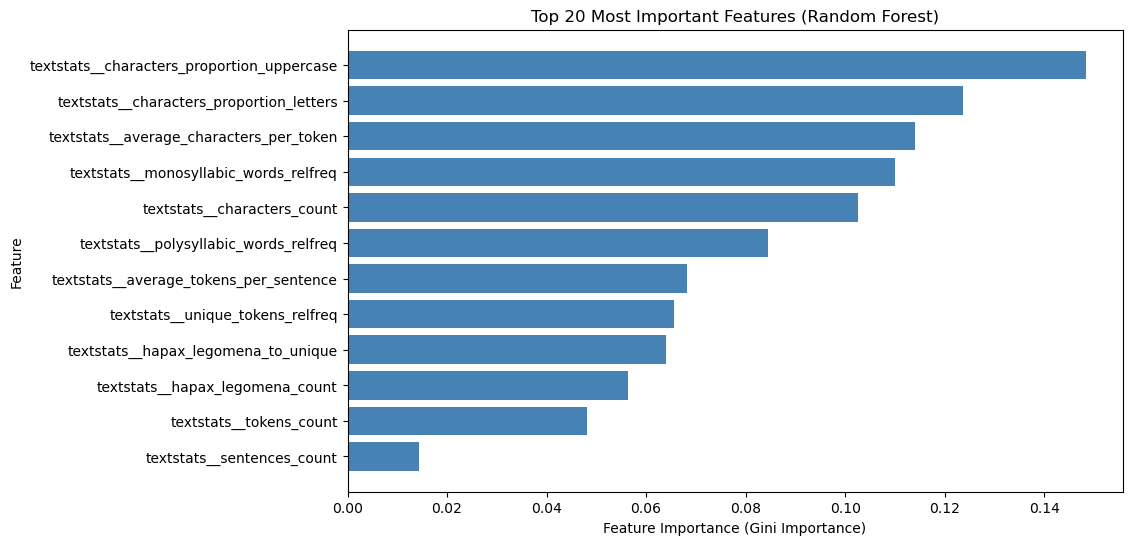

,Feature,Importance
9,textstats__characters_proportion_uppercase,0.148331
8,textstats__characters_proportion_letters,0.123728
6,textstats__average_characters_per_token,0.114134
3,textstats__monosyllabic_words_relfreq,0.110057
2,textstats__characters_count,0.102687
4,textstats__polysyllabic_words_relfreq,0.084558
7,textstats__average_tokens_per_sentence,0.068166
5,textstats__unique_tokens_relfreq,0.065527
11,textstats__hapax_legomena_to_unique,0.063923
10,textstats__hapax_legomena_count,0.056443


In [41]:
#Evaluate model and investigate model predictions

# Extract trained RF from pipeline
rf = pipeline_rf_basemodel.named_steps['classifier']

# Get feature names from FeatureUnion
feature_names = pipeline_rf_basemodel.named_steps['features'].get_feature_names_out()

# Get feature importances from Random Forest
importances = rf.feature_importances_

# Put in DataFrame for easy sorting
feat_imp = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort by absolute importance
feat_imp = feat_imp.sort_values(by='Importance', ascending=False).head(20)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(feat_imp['Feature'], feat_imp['Importance'], color='steelblue')
plt.xlabel("Feature Importance (Gini Importance)")
plt.ylabel("Feature")
plt.title("Top 20 Most Important Features (Random Forest)")
plt.gca().invert_yaxis()  # Highest on top
plt.show()

display(feat_imp)

In [42]:
# Investigate correct and incorrect predictions

# adjust max rows
pd.set_option('display.max_rows', 7)

# dataframe from y_predicted, y_test and the text
predictions_df = pd.DataFrame(data = {'true': y_test, 'predicted': y_predicted})
y_predicted_probs = pipeline_rf_basemodel.predict_proba(X_test)
y_predicted_probs = np.round(y_predicted_probs, 3)
columns = [f'{target_names[i]}_prob' for i in range(len(target_names))]
predictions_df['predicted'] = predictions_df['predicted'].apply(lambda x: label_names[x])
predictions_df['true'] = predictions_df['true'].apply(lambda x: label_names[x])
predictions_df['correct'] = predictions_df['true'] == predictions_df['predicted']
predictions_df['text'] = X_test
predictions_df = pd.concat([predictions_df, pd.DataFrame(y_predicted_probs, columns=columns)], axis=1)

# output a preview of docs for each cell of confusion matrix ...
for true_target, target_name in enumerate(target_names):
    for predicted_target, target_name in enumerate(target_names):
        if true_target == predicted_target:
            print(f'\nCORRECTLY CLASSIFIED: {target_names[true_target]}')
        else:
            print(f'\n{target_names[true_target]} INCORRECTLY CLASSIFIED as: {target_names[predicted_target]}')
        print('=================================================================')

        display(predictions_df[(predictions_df['true'] == target_names[true_target]) & (predictions_df['predicted'] == target_names[predicted_target])])

pd.set_option('display.max_rows', 60) # setting back to the default


CORRECTLY CLASSIFIED: negative


,true,predicted,correct,text,negative_prob,positive_prob
1,negative,negative,True,When girls become bandwagon fans of the Packers because of Harry. Do y'all even know who Aaron Rodgers is? Or what a 1st down is?,0.775,0.225
3,negative,negative,True,Omg this show is so predictable even for the 3rd ep. Rui En\u2019s ex boyfriend was framed for murder probably\u002c by the rich guy.,0.660,0.340
11,negative,negative,True,The sad part about this is tomorrow Nicki will be the angry black woman who went after poor white girl Miley,0.825,0.175
...,...,...,...,...,...,...
1126,negative,negative,True,"@user @user Islam is an Abrahamic faith, Andrew. It may make you feel a little uneasy but it's the same God you worship. Sorry.""",0.500,0.500
1127,negative,negative,True,kingpin Saudi Arabia posted a record $98 billion budget deficit in 2015 due to the sharp fall in oil prices finance ministry said on Monday,0.860,0.140
1128,negative,negative,True,@user @user I think after Charlie Hebdo the French did NOT react as the US did after 9/11. But they may do this time around.,0.645,0.355



negative INCORRECTLY CLASSIFIED as: positive


,true,predicted,correct,text,negative_prob,positive_prob
5,negative,positive,False,"@user so the thing next Thursday isn't free, you'd have to pay $15 to get in since you don't go to UMBC :/ and it ends at 11:30""",0.435,0.565
7,negative,positive,False,F*** the hurricane party this Tues santospartyhaus w/ @user @user @user @ Santos Party House,0.450,0.550
13,negative,positive,False,@user I haven't been able to watch TVD live these days due to Football. Every Thurs there is high school FB going on at 8pm. Like WTF!,0.420,0.580
...,...,...,...,...,...,...
1101,negative,positive,False,@user @user Yellow journalism. But you know? This may be Harper's Waterloo,0.200,0.800
1102,negative,positive,False,"""Gay marriage is NOT a constitutional right! Not recognized with Christians, Buddists, or Islam for that matter.",0.335,0.665
1116,negative,positive,False,It is reality that ISIS are on the march in Turkey and Erdogan can't wait to receive them with open arms,0.455,0.545



positive INCORRECTLY CLASSIFIED as: negative


,true,predicted,correct,text,negative_prob,positive_prob
0,positive,negative,False,"""National hot dog day, national tequila day, then national dance day... Sounds like a Friday night.""",0.625,0.375
2,positive,negative,False,#US 1st Lady Michelle Obama speaking at the 2015 Beating the Odds Summit to over 130 college-bound students at the pentagon office. &gt;&gt;,0.585,0.415
4,positive,negative,False,"""What a round by Paul Dunne, good luck tomorrow and I hope you win the Open.""",0.560,0.440
...,...,...,...,...,...,...
1118,positive,negative,False,"""this adorable old couple in dunkin literally made my day, he's turning 89 tomorrow and talked to me about how he was drafted for the WWII""",0.685,0.315
1119,positive,negative,False,@user @user I think that was faster win then the rousey fight on Saturday Night!,0.700,0.300
1123,positive,negative,False,PM ready for reply on coal blocks: Congress: New Delhi\u002c Aug 22 (IANS) With the Bharatiya Janata Party (BJP)...,0.535,0.465



CORRECTLY CLASSIFIED: positive


,true,predicted,correct,text,negative_prob,positive_prob
6,positive,positive,True,Can't wait for tomorrow at 9 pm! Chelsea v crystal palace! Hope the blues will win!,0.300,0.700
8,positive,positive,True,"""Thank you @user for the message. I'm very proud to be a Liverpudlian, may i get your follback? #LiverpudlianLoyalitasTanpaBatas #YNWA""",0.425,0.575
9,positive,positive,True,Tom Brady is locked for Thursday. Let the season begin! #RepeatSeason,0.270,0.730
...,...,...,...,...,...,...
1125,positive,positive,True,@user call Hafiz saeed sir he may help u out. Maybe Pope can b handy . Try it.,0.325,0.675
1129,positive,positive,True,Beautiful Bouquet with our Beautiful Bentley #bride #groom #wedding #wednesday #weddingcars #love #Repost...,0.415,0.585
1130,positive,positive,True,Hold on... Sam Smith may do the theme to Spectre!? Dope!!!!!! #007 #SPECTRE #JamesBond,0.190,0.810


## Lexicon VADER

In [43]:
pipeline_rf_vader = Pipeline([
    # Step 1: Clean text with character normalization
    ('cleaner', TextCleaner(
        strip_whitespace=True,
        character_replacements={"’": "'", '“': '"', '”': '"'}
    )),
    
    # Step 2: SpaCy preprocessing
    ('spacy', SpacyPreprocessor(feature_store=feature_store)),
    
    # Step 3: Feature extraction
    ('features', FeatureUnion([
        
        # # Token features with TF-IDF + bigrams
        # ('tokens',
        #     Pipeline([
        #         ('spacy_token_vectorizer', TokensVectorizer(
        #             feature_store=feature_store,
        #             vectorizer_type='tfidf',
        #             max_features=2000,
        #             lowercase=False,
        #             remove_punctuation=False,
        #             stop_words=stop_words,
        #             ngram_range=(1, 2)
        #         )),
        #         ('scaler', StandardScaler(with_mean=False)),
        #         # ('selector', SelectKBest(score_func=mutual_info_classif, k=500)), # optional feature selection
        #     ], verbose=True)
        # ),
        
        # # POS features
        # ('pos',
        #     Pipeline([
        #         ('spacy_pos_vectorizer', POSVectorizer(feature_store=feature_store)),
        #         ('scaler', StandardScaler(with_mean=False)),
        #     ], verbose=True)
        # ),

        
        # Text-level statistics (length, readability, etc.)
        ('textstats',
            Pipeline([
                ('textstats_vectorizer', TextstatsTransformer(feature_store=feature_store)),
                ('scaler', StandardScaler(with_mean=False)),
            ], verbose=True)
        ),

         # #--- Lexicon features (Empath) ---
         # ('lexicon_empath',
         #     Pipeline([
         #         ('lexicon_vectorizer', LexiconCountVectorizer(
         #             feature_store=feature_store,
         #             lexicons=empath_lexicons
         #         )),
         #         ('scaler', StandardScaler(with_mean=False)),
         #     ])
         # ),

        # --- Lexicon features (VADER) ---
        ('vader_lexicons',
            Pipeline([
                ('lexicon_vectorizer', LexiconCountVectorizer(
                    feature_store=feature_store,
                    lexicons=vader_lexicons
                )),
                ('scaler', StandardScaler(with_mean=False)),
            ])
        ),
    ], verbose=True)),
    
    # Step 4: Classifier (Random Forest)
    ('classifier', RandomForestClassifier(
        n_estimators=200,        # number of trees
        max_depth=50,            # control split depth from root
        class_weight="balanced", # handle imbalance data
        random_state=42,
        n_jobs=-1                # parallelize across all cores
    ))
], verbose=True)

# Display pipeline structure
display(pipeline_rf_vader)

Pipeline(steps=[('cleaner',
                 TextCleaner(character_replacements={'’': "'", '“': '"',
                                                     '”': '"'},
                             strip_whitespace=True)),
                ('spacy',
                 SpacyPreprocessor(feature_store=<textplumber.store.TextFeatureStore object at 0x7fa2c2108380>)),
                ('features',
                 FeatureUnion(transformer_list=[('textstats',
                                                 Pipeline(steps=[('textstats_vectorizer',
                                                                  TextstatsTransformer(feature_store=<text...
                                                                                                             '(-:<': -0.4,
                                                                                                             '(-:O': 1.5,
                                                                                                             '(-:o': 1.5,
                                                                                                             '(-:{': -0.1,
                                                                                                             '(-:|>*': 1.9,
                                                                                                             '(-;': 1.3,
                                                                                                             '(-;|': 2.1,
                                                                                                             '(8': 2.6,
                                                                                                             '(:': 2.2,
                                                                                                             '(:0': 2.4,
                                                                                                             '(:<': -0.2,
                                                                                                             '(:O': 2.5,
                                                                                                             '(:o': 2.5,
                                                                                                             '(;': 1.1,
                                                                                                             '(;<': 0.3, ...}})),
                                                                 ('scaler',
                                                                  StandardScaler(with_mean=False))]))],
                              verbose=True)),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced', max_depth=50,
                                        n_estimators=200, n_jobs=-1,
                                        random_state=42))],
         verbose=True)

In [44]:
pipeline_rf_vader.fit(X_train, y_train)

[Pipeline] ........... (step 1 of 4) Processing cleaner, total=   0.1s
[Pipeline] ............. (step 2 of 4) Processing spacy, total=   0.9s
[Pipeline]  (step 1 of 2) Processing textstats_vectorizer, total=   1.0s
[Pipeline] ............ (step 2 of 2) Processing scaler, total=   0.0s
[FeatureUnion] ..... (step 1 of 2) Processing textstats, total=   1.1s
[FeatureUnion]  (step 2 of 2) Processing vader_lexicons, total=   7.0s
[Pipeline] .......... (step 3 of 4) Processing features, total=   8.1s
[Pipeline] ........ (step 4 of 4) Processing classifier, total=   0.8s


Pipeline(steps=[('cleaner',
                 TextCleaner(character_replacements={'’': "'", '“': '"',
                                                     '”': '"'},
                             strip_whitespace=True)),
                ('spacy',
                 SpacyPreprocessor(feature_store=<textplumber.store.TextFeatureStore object at 0x7fa2c2108380>)),
                ('features',
                 FeatureUnion(transformer_list=[('textstats',
                                                 Pipeline(steps=[('textstats_vectorizer',
                                                                  TextstatsTransformer(feature_store=<text...
                                                                                                             '(-:<': -0.4,
                                                                                                             '(-:O': 1.5,
                                                                                                             '(-:o': 1.5,
                                                                                                             '(-:{': -0.1,
                                                                                                             '(-:|>*': 1.9,
                                                                                                             '(-;': 1.3,
                                                                                                             '(-;|': 2.1,
                                                                                                             '(8': 2.6,
                                                                                                             '(:': 2.2,
                                                                                                             '(:0': 2.4,
                                                                                                             '(:<': -0.2,
                                                                                                             '(:O': 2.5,
                                                                                                             '(:o': 2.5,
                                                                                                             '(;': 1.1,
                                                                                                             '(;<': 0.3, ...}})),
                                                                 ('scaler',
                                                                  StandardScaler(with_mean=False))]))],
                              verbose=True)),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced', max_depth=50,
                                        n_estimators=200, n_jobs=-1,
                                        random_state=42))],
         verbose=True)

In [45]:
# confusion matrix
y_predicted = pipeline_rf_vader.predict(X_test)
print(classification_report(y_test, y_predicted, target_names = target_names, digits=3, zero_division=0))
plot_confusion_matrix(y_test, y_predicted, target_classes, target_names)

              precision    recall  f1-score   support

    negative      0.328     0.612     0.427       312
    positive      0.779     0.521     0.625       819

    accuracy                          0.546      1131
   macro avg      0.553     0.567     0.526      1131
weighted avg      0.655     0.546     0.570      1131



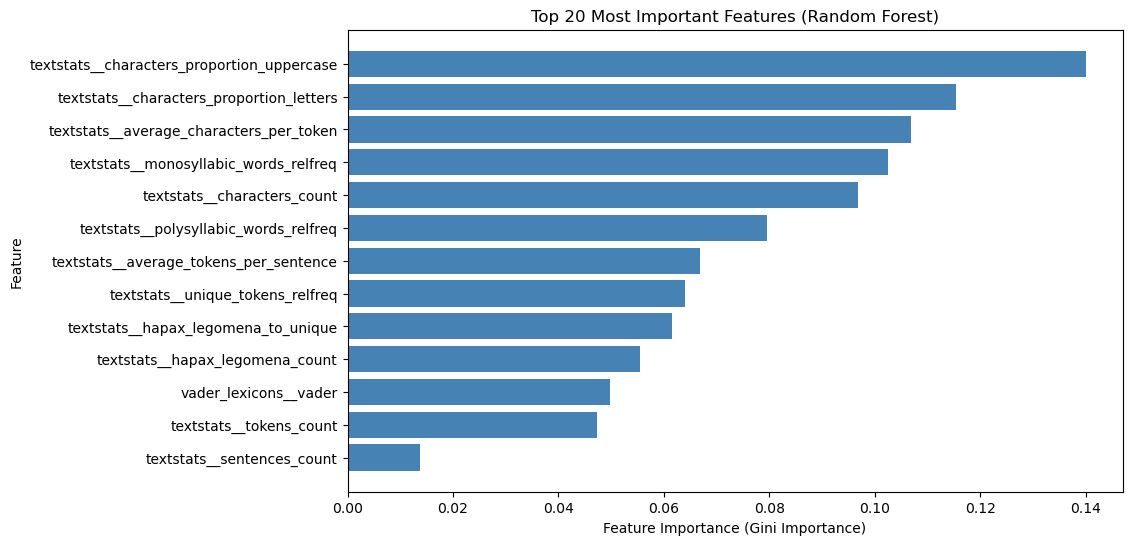

,Feature,Importance
9,textstats__characters_proportion_uppercase,0.139990
8,textstats__characters_proportion_letters,0.115404
6,textstats__average_characters_per_token,0.106948
3,textstats__monosyllabic_words_relfreq,0.102465
2,textstats__characters_count,0.096848
4,textstats__polysyllabic_words_relfreq,0.079525
7,textstats__average_tokens_per_sentence,0.066891
5,textstats__unique_tokens_relfreq,0.064008
11,textstats__hapax_legomena_to_unique,0.061527
10,textstats__hapax_legomena_count,0.055465


In [46]:
#### Evaluate model and investigate model predictions

# Extract trained RF from pipeline
rf = pipeline_rf_vader.named_steps['classifier']

# Get feature names from FeatureUnion
feature_names = pipeline_rf_vader.named_steps['features'].get_feature_names_out()

# Get feature importances from Random Forest
importances = rf.feature_importances_

# Put in DataFrame for easy sorting
feat_imp = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort by absolute importance
feat_imp = feat_imp.sort_values(by='Importance', ascending=False).head(20)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(feat_imp['Feature'], feat_imp['Importance'], color='steelblue')
plt.xlabel("Feature Importance (Gini Importance)")
plt.ylabel("Feature")
plt.title("Top 20 Most Important Features (Random Forest)")
plt.gca().invert_yaxis()  # Highest on top
plt.show()

display(feat_imp)

In [47]:
# Investigate correct and incorrect predictions

# adjust max rows
pd.set_option('display.max_rows', 7) # show all rows

# dataframe from y_predicted, y_test and the text
predictions_df = pd.DataFrame(data = {'true': y_test, 'predicted': y_predicted})
y_predicted_probs = pipeline_rf_vader.predict_proba(X_test)
y_predicted_probs = np.round(y_predicted_probs, 3)
columns = [f'{target_names[i]}_prob' for i in range(len(target_names))]
predictions_df['predicted'] = predictions_df['predicted'].apply(lambda x: label_names[x])
predictions_df['true'] = predictions_df['true'].apply(lambda x: label_names[x])
predictions_df['correct'] = predictions_df['true'] == predictions_df['predicted']
predictions_df['text'] = X_test
predictions_df = pd.concat([predictions_df, pd.DataFrame(y_predicted_probs, columns=columns)], axis=1)

# output a preview of docs for each cell of confusion matrix ...
for true_target, target_name in enumerate(target_names):
    for predicted_target, target_name in enumerate(target_names):
        if true_target == predicted_target:
            print(f'\nCORRECTLY CLASSIFIED: {target_names[true_target]}')
        else:
            print(f'\n{target_names[true_target]} INCORRECTLY CLASSIFIED as: {target_names[predicted_target]}')
        print('=================================================================')

        display(predictions_df[(predictions_df['true'] == target_names[true_target]) & (predictions_df['predicted'] == target_names[predicted_target])])

pd.set_option('display.max_rows', 60) # setting back to the default


CORRECTLY CLASSIFIED: negative


,true,predicted,correct,text,negative_prob,positive_prob
1,negative,negative,True,When girls become bandwagon fans of the Packers because of Harry. Do y'all even know who Aaron Rodgers is? Or what a 1st down is?,0.595,0.405
3,negative,negative,True,Omg this show is so predictable even for the 3rd ep. Rui En\u2019s ex boyfriend was framed for murder probably\u002c by the rich guy.,0.675,0.325
7,negative,negative,True,F*** the hurricane party this Tues santospartyhaus w/ @user @user @user @ Santos Party House,0.530,0.470
...,...,...,...,...,...,...
1122,negative,negative,True,Disappointed the Knicks vs Nets game got canceled tonight\u002c but I\u2019m even more hyped for Knicks vs Heat on Friday!,0.540,0.460
1127,negative,negative,True,kingpin Saudi Arabia posted a record $98 billion budget deficit in 2015 due to the sharp fall in oil prices finance ministry said on Monday,0.880,0.120
1128,negative,negative,True,@user @user I think after Charlie Hebdo the French did NOT react as the US did after 9/11. But they may do this time around.,0.540,0.460



negative INCORRECTLY CLASSIFIED as: positive


,true,predicted,correct,text,negative_prob,positive_prob
5,negative,positive,False,"@user so the thing next Thursday isn't free, you'd have to pay $15 to get in since you don't go to UMBC :/ and it ends at 11:30""",0.450,0.550
13,negative,positive,False,@user I haven't been able to watch TVD live these days due to Football. Every Thurs there is high school FB going on at 8pm. Like WTF!,0.400,0.600
31,negative,positive,False,I don't have the money for this NINTENDO STOP IT,0.265,0.735
...,...,...,...,...,...,...
1114,negative,positive,False,"""More like boring eagles""""""""""""""""@Tunnyking: C'mon bro, Go out and support the Super Eagles #RT @user I hate international breaks""",0.410,0.590
1116,negative,positive,False,It is reality that ISIS are on the march in Turkey and Erdogan can't wait to receive them with open arms,0.405,0.595
1126,negative,positive,False,"@user @user Islam is an Abrahamic faith, Andrew. It may make you feel a little uneasy but it's the same God you worship. Sorry.""",0.450,0.550



positive INCORRECTLY CLASSIFIED as: negative


,true,predicted,correct,text,negative_prob,positive_prob
0,positive,negative,False,"""National hot dog day, national tequila day, then national dance day... Sounds like a Friday night.""",0.610,0.390
2,positive,negative,False,#US 1st Lady Michelle Obama speaking at the 2015 Beating the Odds Summit to over 130 college-bound students at the pentagon office. &gt;&gt;,0.550,0.450
4,positive,negative,False,"""What a round by Paul Dunne, good luck tomorrow and I hope you win the Open.""",0.545,0.455
...,...,...,...,...,...,...
1118,positive,negative,False,"""this adorable old couple in dunkin literally made my day, he's turning 89 tomorrow and talked to me about how he was drafted for the WWII""",0.600,0.400
1119,positive,negative,False,@user @user I think that was faster win then the rousey fight on Saturday Night!,0.655,0.345
1123,positive,negative,False,PM ready for reply on coal blocks: Congress: New Delhi\u002c Aug 22 (IANS) With the Bharatiya Janata Party (BJP)...,0.520,0.480



CORRECTLY CLASSIFIED: positive


,true,predicted,correct,text,negative_prob,positive_prob
6,positive,positive,True,Can't wait for tomorrow at 9 pm! Chelsea v crystal palace! Hope the blues will win!,0.345,0.655
8,positive,positive,True,"""Thank you @user for the message. I'm very proud to be a Liverpudlian, may i get your follback? #LiverpudlianLoyalitasTanpaBatas #YNWA""",0.415,0.585
9,positive,positive,True,Tom Brady is locked for Thursday. Let the season begin! #RepeatSeason,0.300,0.700
...,...,...,...,...,...,...
1125,positive,positive,True,@user call Hafiz saeed sir he may help u out. Maybe Pope can b handy . Try it.,0.420,0.580
1129,positive,positive,True,Beautiful Bouquet with our Beautiful Bentley #bride #groom #wedding #wednesday #weddingcars #love #Repost...,0.475,0.525
1130,positive,positive,True,Hold on... Sam Smith may do the theme to Spectre!? Dope!!!!!! #007 #SPECTRE #JamesBond,0.235,0.765


## Lexicon VADER and Empath

In [48]:
pipeline_rf_vader_empath = Pipeline([
    # Step 1: Clean text with character normalization
    ('cleaner', TextCleaner(
        strip_whitespace=True,
        character_replacements={"’": "'", '“': '"', '”': '"'}
    )),
    
    # Step 2: SpaCy preprocessing
    ('spacy', SpacyPreprocessor(feature_store=feature_store)),
    
    # Step 3: Feature extraction
    ('features', FeatureUnion([
        
        # # Token features with TF-IDF + bigrams
        # ('tokens',
        #     Pipeline([
        #         ('spacy_token_vectorizer', TokensVectorizer(
        #             feature_store=feature_store,
        #             vectorizer_type='tfidf',
        #             max_features=2000,
        #             lowercase=False,
        #             remove_punctuation=False,
        #             stop_words=stop_words,
        #             ngram_range=(1, 2)
        #         )),
        #         ('scaler', StandardScaler(with_mean=False)),
        #         # ('selector', SelectKBest(score_func=mutual_info_classif, k=500)), # optional feature selection
        #     ], verbose=True)
        # ),
        
        # # POS features
        # ('pos',
        #     Pipeline([
        #         ('spacy_pos_vectorizer', POSVectorizer(feature_store=feature_store)),
        #         ('scaler', StandardScaler(with_mean=False)),
        #     ], verbose=True)
        # ),

        
        # Text-level statistics (length, readability, etc.)
        ('textstats',
            Pipeline([
                ('textstats_vectorizer', TextstatsTransformer(feature_store=feature_store)),
                ('scaler', StandardScaler(with_mean=False)),
            ], verbose=True)
        ),

         #--- Lexicon features (Empath) ---
         ('lexicon_empath',
             Pipeline([
                 ('lexicon_vectorizer', LexiconCountVectorizer(
                     feature_store=feature_store,
                     lexicons=empath_lexicons
                 )),
                 ('scaler', StandardScaler(with_mean=False)),
             ])
         ),

        # --- Lexicon features (VADER) ---
        ('vader_lexicons',
            Pipeline([
                ('lexicon_vectorizer', LexiconCountVectorizer(
                    feature_store=feature_store,
                    lexicons=vader_lexicons
                )),
                ('scaler', StandardScaler(with_mean=False)),
            ])
        ),
    ], verbose=True)),
    
    # Step 4: Classifier (Random Forest)
    ('classifier', RandomForestClassifier(
        n_estimators=200,        # number of trees
        max_depth=50,            # control split depth from root
        class_weight="balanced", # handle imbalance data
        random_state=42,
        n_jobs=-1                # parallelize across all cores
    ))
], verbose=True)

# Display pipeline structure
display(pipeline_rf_vader_empath)

Pipeline(steps=[('cleaner',
                 TextCleaner(character_replacements={'’': "'", '“': '"',
                                                     '”': '"'},
                             strip_whitespace=True)),
                ('spacy',
                 SpacyPreprocessor(feature_store=<textplumber.store.TextFeatureStore object at 0x7fa2c2108380>)),
                ('features',
                 FeatureUnion(transformer_list=[('textstats',
                                                 Pipeline(steps=[('textstats_vectorizer',
                                                                  TextstatsTransformer(feature_store=<text...
                                                                                                             '(-:<': -0.4,
                                                                                                             '(-:O': 1.5,
                                                                                                             '(-:o': 1.5,
                                                                                                             '(-:{': -0.1,
                                                                                                             '(-:|>*': 1.9,
                                                                                                             '(-;': 1.3,
                                                                                                             '(-;|': 2.1,
                                                                                                             '(8': 2.6,
                                                                                                             '(:': 2.2,
                                                                                                             '(:0': 2.4,
                                                                                                             '(:<': -0.2,
                                                                                                             '(:O': 2.5,
                                                                                                             '(:o': 2.5,
                                                                                                             '(;': 1.1,
                                                                                                             '(;<': 0.3, ...}})),
                                                                 ('scaler',
                                                                  StandardScaler(with_mean=False))]))],
                              verbose=True)),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced', max_depth=50,
                                        n_estimators=200, n_jobs=-1,
                                        random_state=42))],
         verbose=True)

In [49]:
pipeline_rf_vader_empath.fit(X_train, y_train)

[Pipeline] ........... (step 1 of 4) Processing cleaner, total=   0.1s
[Pipeline] ............. (step 2 of 4) Processing spacy, total=   0.9s
[Pipeline]  (step 1 of 2) Processing textstats_vectorizer, total=   0.8s
[Pipeline] ............ (step 2 of 2) Processing scaler, total=   0.0s
[FeatureUnion] ..... (step 1 of 3) Processing textstats, total=   0.9s
[FeatureUnion]  (step 2 of 3) Processing lexicon_empath, total=  15.6s
[FeatureUnion]  (step 3 of 3) Processing vader_lexicons, total=   7.1s
[Pipeline] .......... (step 3 of 4) Processing features, total=  23.6s
[Pipeline] ........ (step 4 of 4) Processing classifier, total=   0.8s


Pipeline(steps=[('cleaner',
                 TextCleaner(character_replacements={'’': "'", '“': '"',
                                                     '”': '"'},
                             strip_whitespace=True)),
                ('spacy',
                 SpacyPreprocessor(feature_store=<textplumber.store.TextFeatureStore object at 0x7fa2c2108380>)),
                ('features',
                 FeatureUnion(transformer_list=[('textstats',
                                                 Pipeline(steps=[('textstats_vectorizer',
                                                                  TextstatsTransformer(feature_store=<text...
                                                                                                             '(-:<': -0.4,
                                                                                                             '(-:O': 1.5,
                                                                                                             '(-:o': 1.5,
                                                                                                             '(-:{': -0.1,
                                                                                                             '(-:|>*': 1.9,
                                                                                                             '(-;': 1.3,
                                                                                                             '(-;|': 2.1,
                                                                                                             '(8': 2.6,
                                                                                                             '(:': 2.2,
                                                                                                             '(:0': 2.4,
                                                                                                             '(:<': -0.2,
                                                                                                             '(:O': 2.5,
                                                                                                             '(:o': 2.5,
                                                                                                             '(;': 1.1,
                                                                                                             '(;<': 0.3, ...}})),
                                                                 ('scaler',
                                                                  StandardScaler(with_mean=False))]))],
                              verbose=True)),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced', max_depth=50,
                                        n_estimators=200, n_jobs=-1,
                                        random_state=42))],
         verbose=True)

In [50]:
# confusion matrix
y_predicted = pipeline_rf_vader_empath.predict(X_test)
print(classification_report(y_test, y_predicted, target_names = target_names, digits=3, zero_division=0))
plot_confusion_matrix(y_test, y_predicted, target_classes, target_names)

              precision    recall  f1-score   support

    negative      0.535     0.756     0.627       312
    positive      0.890     0.750     0.814       819

    accuracy                          0.752      1131
   macro avg      0.713     0.753     0.720      1131
weighted avg      0.792     0.752     0.762      1131



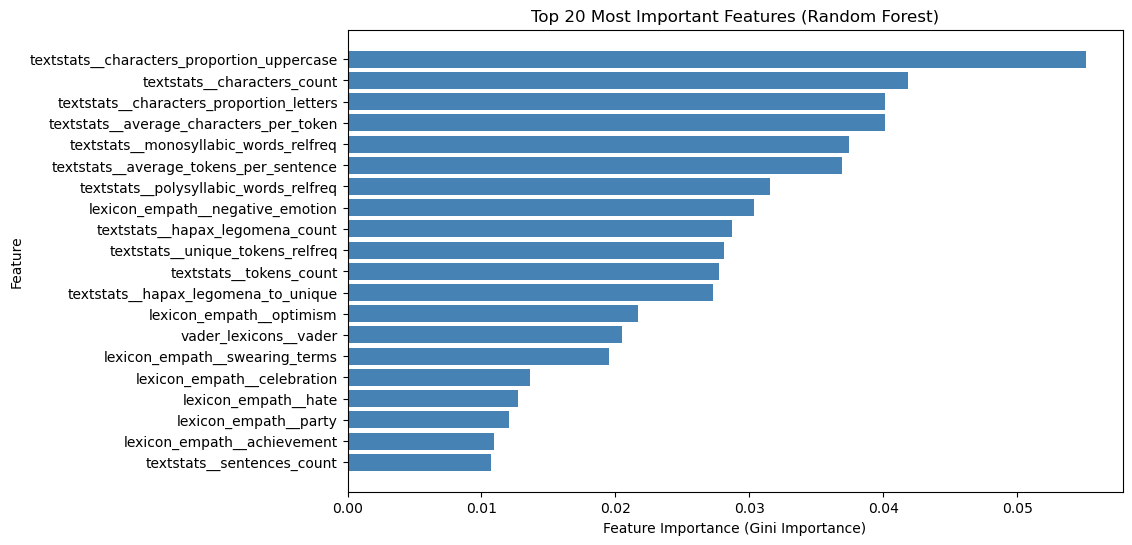

,Feature,Importance
9,textstats__characters_proportion_uppercase,0.055111
2,textstats__characters_count,0.041874
8,textstats__characters_proportion_letters,0.040154
6,textstats__average_characters_per_token,0.040124
3,textstats__monosyllabic_words_relfreq,0.037426
7,textstats__average_tokens_per_sentence,0.036897
4,textstats__polysyllabic_words_relfreq,0.031520
185,lexicon_empath__negative_emotion,0.030323
10,textstats__hapax_legomena_count,0.028731
5,textstats__unique_tokens_relfreq,0.028116


In [51]:
# Evaluate model and investigate model predictions

# Extract trained RF from pipeline
rf = pipeline_rf_vader_empath.named_steps['classifier']

# Get feature names from FeatureUnion
feature_names = pipeline_rf_vader_empath.named_steps['features'].get_feature_names_out()

# Get feature importances from Random Forest
importances = rf.feature_importances_

# Put in DataFrame for easy sorting
feat_imp = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort by absolute importance
feat_imp = feat_imp.sort_values(by='Importance', ascending=False).head(20)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(feat_imp['Feature'], feat_imp['Importance'], color='steelblue')
plt.xlabel("Feature Importance (Gini Importance)")
plt.ylabel("Feature")
plt.title("Top 20 Most Important Features (Random Forest)")
plt.gca().invert_yaxis()  # Highest on top
plt.show()

display(feat_imp)


In [52]:
# Investigate correct and incorrect predictions

# adjust max rows
pd.set_option('display.max_rows', 7) # show all rows

# dataframe from y_predicted, y_test and the text
predictions_df = pd.DataFrame(data = {'true': y_test, 'predicted': y_predicted})
y_predicted_probs = pipeline_rf_vader_empath.predict_proba(X_test)
y_predicted_probs = np.round(y_predicted_probs, 3)
columns = [f'{target_names[i]}_prob' for i in range(len(target_names))]
predictions_df['predicted'] = predictions_df['predicted'].apply(lambda x: label_names[x])
predictions_df['true'] = predictions_df['true'].apply(lambda x: label_names[x])
predictions_df['correct'] = predictions_df['true'] == predictions_df['predicted']
predictions_df['text'] = X_test
predictions_df = pd.concat([predictions_df, pd.DataFrame(y_predicted_probs, columns=columns)], axis=1)

# output a preview of docs for each cell of confusion matrix ...
for true_target, target_name in enumerate(target_names):
    for predicted_target, target_name in enumerate(target_names):
        if true_target == predicted_target:
            print(f'\nCORRECTLY CLASSIFIED: {target_names[true_target]}')
        else:
            print(f'\n{target_names[true_target]} INCORRECTLY CLASSIFIED as: {target_names[predicted_target]}')
        print('=================================================================')

        display(predictions_df[(predictions_df['true'] == target_names[true_target]) & (predictions_df['predicted'] == target_names[predicted_target])])

pd.set_option('display.max_rows', 60) # setting back to the default



CORRECTLY CLASSIFIED: negative


,true,predicted,correct,text,negative_prob,positive_prob
1,negative,negative,True,When girls become bandwagon fans of the Packers because of Harry. Do y'all even know who Aaron Rodgers is? Or what a 1st down is?,0.624,0.376
3,negative,negative,True,Omg this show is so predictable even for the 3rd ep. Rui En\u2019s ex boyfriend was framed for murder probably\u002c by the rich guy.,0.693,0.307
5,negative,negative,True,"@user so the thing next Thursday isn't free, you'd have to pay $15 to get in since you don't go to UMBC :/ and it ends at 11:30""",0.503,0.497
...,...,...,...,...,...,...
1126,negative,negative,True,"@user @user Islam is an Abrahamic faith, Andrew. It may make you feel a little uneasy but it's the same God you worship. Sorry.""",0.515,0.485
1127,negative,negative,True,kingpin Saudi Arabia posted a record $98 billion budget deficit in 2015 due to the sharp fall in oil prices finance ministry said on Monday,0.615,0.385
1128,negative,negative,True,@user @user I think after Charlie Hebdo the French did NOT react as the US did after 9/11. But they may do this time around.,0.614,0.386



negative INCORRECTLY CLASSIFIED as: positive


,true,predicted,correct,text,negative_prob,positive_prob
7,negative,positive,False,F*** the hurricane party this Tues santospartyhaus w/ @user @user @user @ Santos Party House,0.340,0.660
13,negative,positive,False,@user I haven't been able to watch TVD live these days due to Football. Every Thurs there is high school FB going on at 8pm. Like WTF!,0.474,0.526
39,negative,positive,False,"@user @user Bet you haven't donated much to Rick Perry, if at all. He's a loser &amp; someone has to be the 1st to go out.",0.343,0.657
...,...,...,...,...,...,...
1081,negative,positive,False,GOP has set the bar very low with a 4th cycle promoting a grossly UN-AMERICAN idea: POTUS as elected autocrat. #Civics101,0.496,0.504
1101,negative,positive,False,@user @user Yellow journalism. But you know? This may be Harper's Waterloo,0.226,0.774
1116,negative,positive,False,It is reality that ISIS are on the march in Turkey and Erdogan can't wait to receive them with open arms,0.385,0.615



positive INCORRECTLY CLASSIFIED as: negative


,true,predicted,correct,text,negative_prob,positive_prob
2,positive,negative,False,#US 1st Lady Michelle Obama speaking at the 2015 Beating the Odds Summit to over 130 college-bound students at the pentagon office. &gt;&gt;,0.705,0.295
17,positive,negative,False,tomorrow I've to wake up early so Zayn's erformance on VMA better be true otherwise u'll regret for playing with my emotions and sleep,0.590,0.410
18,positive,negative,False,"@user told you because you said """"Generally 15 August comes near Eid week"""". It happens for only 2 years after every 30 years. :)""",0.759,0.241
...,...,...,...,...,...,...
1118,positive,negative,False,"""this adorable old couple in dunkin literally made my day, he's turning 89 tomorrow and talked to me about how he was drafted for the WWII""",0.516,0.484
1119,positive,negative,False,@user @user I think that was faster win then the rousey fight on Saturday Night!,0.570,0.430
1123,positive,negative,False,PM ready for reply on coal blocks: Congress: New Delhi\u002c Aug 22 (IANS) With the Bharatiya Janata Party (BJP)...,0.515,0.485



CORRECTLY CLASSIFIED: positive


,true,predicted,correct,text,negative_prob,positive_prob
0,positive,positive,True,"""National hot dog day, national tequila day, then national dance day... Sounds like a Friday night.""",0.240,0.760
4,positive,positive,True,"""What a round by Paul Dunne, good luck tomorrow and I hope you win the Open.""",0.255,0.745
6,positive,positive,True,Can't wait for tomorrow at 9 pm! Chelsea v crystal palace! Hope the blues will win!,0.125,0.875
...,...,...,...,...,...,...
1125,positive,positive,True,@user call Hafiz saeed sir he may help u out. Maybe Pope can b handy . Try it.,0.470,0.530
1129,positive,positive,True,Beautiful Bouquet with our Beautiful Bentley #bride #groom #wedding #wednesday #weddingcars #love #Repost...,0.095,0.905
1130,positive,positive,True,Hold on... Sam Smith may do the theme to Spectre!? Dope!!!!!! #007 #SPECTRE #JamesBond,0.220,0.780


## POS + Lexicon VADAR & Empath

In [53]:
pipeline_rf_pos_vader_empath = Pipeline([
    # Step 1: Clean text with character normalization
    ('cleaner', TextCleaner(
        strip_whitespace=True,
        character_replacements={"’": "'", '“': '"', '”': '"'}
    )),
    
    # Step 2: SpaCy preprocessing
    ('spacy', SpacyPreprocessor(feature_store=feature_store)),
    
    # Step 3: Feature extraction
    ('features', FeatureUnion([
        
        # # Token features with TF-IDF + bigrams
        # ('tokens',
        #     Pipeline([
        #         ('spacy_token_vectorizer', TokensVectorizer(
        #             feature_store=feature_store,
        #             vectorizer_type='tfidf',
        #             max_features=2000,
        #             lowercase=False,
        #             remove_punctuation=False,
        #             stop_words=stop_words,
        #             ngram_range=(1, 2)
        #         )),
        #         ('scaler', StandardScaler(with_mean=False)),
        #         # ('selector', SelectKBest(score_func=mutual_info_classif, k=500)), # optional feature selection
        #     ], verbose=True)
        # ),
        
        # POS features
        ('pos',
            Pipeline([
                ('spacy_pos_vectorizer', POSVectorizer(feature_store=feature_store)),
                ('scaler', StandardScaler(with_mean=False)),
            ], verbose=True)
        ),

        
        # Text-level statistics (length, readability, etc.)
        ('textstats',
            Pipeline([
                ('textstats_vectorizer', TextstatsTransformer(feature_store=feature_store)),
                ('scaler', StandardScaler(with_mean=False)),
            ], verbose=True)
        ),

         #--- Lexicon features (Empath) ---
         ('lexicon_empath',
             Pipeline([
                 ('lexicon_vectorizer', LexiconCountVectorizer(
                     feature_store=feature_store,
                     lexicons=empath_lexicons
                 )),
                 ('scaler', StandardScaler(with_mean=False)),
             ])
         ),

        # --- Lexicon features (VADER) ---
        ('vader_lexicons',
            Pipeline([
                ('lexicon_vectorizer', LexiconCountVectorizer(
                    feature_store=feature_store,
                    lexicons=vader_lexicons
                )),
                ('scaler', StandardScaler(with_mean=False)),
            ])
        ),
    ], verbose=True)),
    
    # Step 4: Classifier (Random Forest)
    ('classifier', RandomForestClassifier(
        n_estimators=200,        # number of trees
        max_depth=50,            # control split depth from root
        class_weight="balanced", # handle imbalance data
        random_state=42,
        n_jobs=-1                # parallelize across all cores
    ))
], verbose=True)

# Display pipeline structure
display(pipeline_rf_pos_vader_empath)

Pipeline(steps=[('cleaner',
                 TextCleaner(character_replacements={'’': "'", '“': '"',
                                                     '”': '"'},
                             strip_whitespace=True)),
                ('spacy',
                 SpacyPreprocessor(feature_store=<textplumber.store.TextFeatureStore object at 0x7fa2c2108380>)),
                ('features',
                 FeatureUnion(transformer_list=[('pos',
                                                 Pipeline(steps=[('spacy_pos_vectorizer',
                                                                  POSVectorizer(feature_store=<textplumber.store...
                                                                                                             '(-:<': -0.4,
                                                                                                             '(-:O': 1.5,
                                                                                                             '(-:o': 1.5,
                                                                                                             '(-:{': -0.1,
                                                                                                             '(-:|>*': 1.9,
                                                                                                             '(-;': 1.3,
                                                                                                             '(-;|': 2.1,
                                                                                                             '(8': 2.6,
                                                                                                             '(:': 2.2,
                                                                                                             '(:0': 2.4,
                                                                                                             '(:<': -0.2,
                                                                                                             '(:O': 2.5,
                                                                                                             '(:o': 2.5,
                                                                                                             '(;': 1.1,
                                                                                                             '(;<': 0.3, ...}})),
                                                                 ('scaler',
                                                                  StandardScaler(with_mean=False))]))],
                              verbose=True)),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced', max_depth=50,
                                        n_estimators=200, n_jobs=-1,
                                        random_state=42))],
         verbose=True)

In [ ]:
pipeline_rf_pos_vader_empath.fit(X_train, y_train)

[Pipeline] ........... (step 1 of 4) Processing cleaner, total=   0.1s
[Pipeline] ............. (step 2 of 4) Processing spacy, total=   0.9s
[Pipeline]  (step 1 of 2) Processing spacy_pos_vectorizer, total=   1.9s
[Pipeline] ............ (step 2 of 2) Processing scaler, total=   0.0s
[FeatureUnion] ........... (step 1 of 4) Processing pos, total=   1.9s
[Pipeline]  (step 1 of 2) Processing textstats_vectorizer, total=   0.9s
[Pipeline] ............ (step 2 of 2) Processing scaler, total=   0.0s
[FeatureUnion] ..... (step 2 of 4) Processing textstats, total=   0.9s
[FeatureUnion]  (step 3 of 4) Processing lexicon_empath, total=  15.7s
[FeatureUnion]  (step 4 of 4) Processing vader_lexicons, total=   6.9s
[Pipeline] .......... (step 3 of 4) Processing features, total=  25.4s
[Pipeline] ........ (step 4 of 4) Processing classifier, total=   3.6s


In [ ]:
# confusion matrix
y_predicted = pipeline_rf_pos_vader_empath.predict(X_test)
print(classification_report(y_test, y_predicted, target_names = target_names, digits=3, zero_division=0))
plot_confusion_matrix(y_test, y_predicted, target_classes, target_names)

In [ ]:
# Evaluate model and investigate model predictions

# Extract trained RF from pipeline
rf = pipeline_rf_pos_vader_empath.named_steps['classifier']

# Get feature names from FeatureUnion
feature_names = pipeline_rf_pos_vader_empath.named_steps['features'].get_feature_names_out()

# Get feature importances from Random Forest
importances = rf.feature_importances_

# Put in DataFrame for easy sorting
feat_imp = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort by absolute importance
feat_imp = feat_imp.sort_values(by='Importance', ascending=False).head(20)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(feat_imp['Feature'], feat_imp['Importance'], color='steelblue')
plt.xlabel("Feature Importance (Gini Importance)")
plt.ylabel("Feature")
plt.title("Top 20 Most Important Features (Random Forest)")
plt.gca().invert_yaxis()  # Highest on top
plt.show()

display(feat_imp)


In [ ]:
# Investigate correct and incorrect predictions

# adjust max rows
pd.set_option('display.max_rows', 7) # show all rows

# dataframe from y_predicted, y_test and the text
predictions_df = pd.DataFrame(data = {'true': y_test, 'predicted': y_predicted})
y_predicted_probs = pipeline_rf_pos_vader_empath.predict_proba(X_test)
y_predicted_probs = np.round(y_predicted_probs, 3)
columns = [f'{target_names[i]}_prob' for i in range(len(target_names))]
predictions_df['predicted'] = predictions_df['predicted'].apply(lambda x: label_names[x])
predictions_df['true'] = predictions_df['true'].apply(lambda x: label_names[x])
predictions_df['correct'] = predictions_df['true'] == predictions_df['predicted']
predictions_df['text'] = X_test
predictions_df = pd.concat([predictions_df, pd.DataFrame(y_predicted_probs, columns=columns)], axis=1)

# output a preview of docs for each cell of confusion matrix ...
for true_target, target_name in enumerate(target_names):
    for predicted_target, target_name in enumerate(target_names):
        if true_target == predicted_target:
            print(f'\nCORRECTLY CLASSIFIED: {target_names[true_target]}')
        else:
            print(f'\n{target_names[true_target]} INCORRECTLY CLASSIFIED as: {target_names[predicted_target]}')
        print('=================================================================')

        display(predictions_df[(predictions_df['true'] == target_names[true_target]) & (predictions_df['predicted'] == target_names[predicted_target])])

pd.set_option('display.max_rows', 60) # setting back to the default


## Token + POS + Lexicon VADAR & Empath

In [ ]:
pipeline_rf_token_pos_vader_empath = Pipeline([
    # Step 1: Clean text with character normalization
    ('cleaner', TextCleaner(
        strip_whitespace=True,
        character_replacements={"’": "'", '“': '"', '”': '"'}
    )),
    
    # Step 2: SpaCy preprocessing
    ('spacy', SpacyPreprocessor(feature_store=feature_store)),
    
    # Step 3: Feature extraction
    ('features', FeatureUnion([
        
        # Token features with TF-IDF + bigrams
        ('tokens',
            Pipeline([
                ('spacy_token_vectorizer', TokensVectorizer(
                    feature_store=feature_store,
                    vectorizer_type='tfidf',
                    max_features=2000,
                    lowercase=False,
                    remove_punctuation=False,
                    stop_words=stop_words,
                    ngram_range=(1, 2)
                )),
                ('scaler', StandardScaler(with_mean=False)),
                # ('selector', SelectKBest(score_func=mutual_info_classif, k=500)), # optional feature selection
            ], verbose=True)
        ),
        
        # POS features
        ('pos',
            Pipeline([
                ('spacy_pos_vectorizer', POSVectorizer(feature_store=feature_store)),
                ('scaler', StandardScaler(with_mean=False)),
            ], verbose=True)
        ),

        
        # Text-level statistics (length, readability, etc.)
        ('textstats',
            Pipeline([
                ('textstats_vectorizer', TextstatsTransformer(feature_store=feature_store)),
                ('scaler', StandardScaler(with_mean=False)),
            ], verbose=True)
        ),

         #--- Lexicon features (Empath) ---
         ('lexicon_empath',
             Pipeline([
                 ('lexicon_vectorizer', LexiconCountVectorizer(
                     feature_store=feature_store,
                     lexicons=empath_lexicons
                 )),
                 ('scaler', StandardScaler(with_mean=False)),
             ])
         ),

        # --- Lexicon features (VADER) ---
        ('vader_lexicons',
            Pipeline([
                ('lexicon_vectorizer', LexiconCountVectorizer(
                    feature_store=feature_store,
                    lexicons=vader_lexicons
                )),
                ('scaler', StandardScaler(with_mean=False)),
            ])
        ),
    ], verbose=True)),
    
    # Step 4: Classifier (Random Forest)
    ('classifier', RandomForestClassifier(
        n_estimators=200,        # number of trees
        max_depth=50,            # control split depth from root
        class_weight="balanced", # handle imbalance data
        random_state=42,
        n_jobs=-1                # parallelize across all cores
    ))
], verbose=True)

# Display pipeline structure
display(pipeline_rf_token_pos_vader_empath)

In [ ]:
pipeline_rf_token_pos_vader_empath.fit(X_train, y_train)

In [ ]:
# confusion matrix
y_predicted = pipeline_rf_token_pos_vader_empath.predict(X_test)
print(classification_report(y_test, y_predicted, target_names = target_names, digits=3, zero_division=0))
plot_confusion_matrix(y_test, y_predicted, target_classes, target_names)

In [ ]:
# Evaluate model and investigate model predictions

# Extract trained RF from pipeline
rf = pipeline_rf_token_pos_vader_empath.named_steps['classifier']

# Get feature names from FeatureUnion
feature_names = pipeline_rf_token_pos_vader_empath.named_steps['features'].get_feature_names_out()

# Get feature importances from Random Forest
importances = rf.feature_importances_

# Put in DataFrame for easy sorting
feat_imp = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort by absolute importance
feat_imp = feat_imp.sort_values(by='Importance', ascending=False).head(20)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(feat_imp['Feature'], feat_imp['Importance'], color='steelblue')
plt.xlabel("Feature Importance (Gini Importance)")
plt.ylabel("Feature")
plt.title("Top 20 Most Important Features (Random Forest)")
plt.gca().invert_yaxis()  # Highest on top
plt.show()

display(feat_imp)


In [ ]:
# Investigate correct and incorrect predictions

# adjust max rows
pd.set_option('display.max_rows', 7) # show all rows

# dataframe from y_predicted, y_test and the text
predictions_df = pd.DataFrame(data = {'true': y_test, 'predicted': y_predicted})
y_predicted_probs = pipeline_rf_token_pos_vader_empath.predict_proba(X_test)
y_predicted_probs = np.round(y_predicted_probs, 3)
columns = [f'{target_names[i]}_prob' for i in range(len(target_names))]
predictions_df['predicted'] = predictions_df['predicted'].apply(lambda x: label_names[x])
predictions_df['true'] = predictions_df['true'].apply(lambda x: label_names[x])
predictions_df['correct'] = predictions_df['true'] == predictions_df['predicted']
predictions_df['text'] = X_test
predictions_df = pd.concat([predictions_df, pd.DataFrame(y_predicted_probs, columns=columns)], axis=1)

# output a preview of docs for each cell of confusion matrix ...
for true_target, target_name in enumerate(target_names):
    for predicted_target, target_name in enumerate(target_names):
        if true_target == predicted_target:
            print(f'\nCORRECTLY CLASSIFIED: {target_names[true_target]}')
        else:
            print(f'\n{target_names[true_target]} INCORRECTLY CLASSIFIED as: {target_names[predicted_target]}')
        print('=================================================================')

        display(predictions_df[(predictions_df['true'] == target_names[true_target]) & (predictions_df['predicted'] == target_names[predicted_target])])

pd.set_option('display.max_rows', 60) # setting back to the default
